In [1]:
import os
import numpy as np
import csv
import glob

import pandas as pd
from ast import literal_eval

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.metrics import mean_squared_error

## Functions for reading in df

In [2]:
keypoints = ['NOSE', 'LEFT_EYE', 'RIGHT_EYE', 'LEFT_EAR', 'RIGHT_EAR', 
             'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 
             'RIGHT_ELBOW', 'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_HIP', 
             'RIGHT_HIP', 'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 
             'RIGHT_ANKLE']

# indeces of keypoints between which we want to draw a line
num_edges = ((0, 1),(0, 2),(0, 3),(0, 4),(3, 1),(4, 2),
             (1, 2),(5, 6),(5, 7),(5, 11),(6, 8),(6, 12),
             (7, 9),(8, 10),(11, 12),(11, 13),(12, 14),
             (13, 15),(14, 16),)

# same list but as keypoint names 
EDGES = (
    ('NOSE', 'LEFT_EYE'),
    ('NOSE', 'RIGHT_EYE'),
    ('NOSE', 'LEFT_EAR'),
    ('NOSE', 'RIGHT_EAR'),
    ('LEFT_EAR', 'LEFT_EYE'),
    ('RIGHT_EAR', 'RIGHT_EYE'),
    ('LEFT_EYE', 'RIGHT_EYE'),
    ('LEFT_SHOULDER', 'RIGHT_SHOULDER'),
    ('LEFT_SHOULDER', 'LEFT_ELBOW'),
    ('LEFT_SHOULDER', 'LEFT_HIP'),
    ('RIGHT_SHOULDER', 'RIGHT_ELBOW'),
    ('RIGHT_SHOULDER', 'RIGHT_HIP'),
    ('LEFT_ELBOW', 'LEFT_WRIST'),
    ('RIGHT_ELBOW', 'RIGHT_WRIST'),
    ('LEFT_HIP', 'RIGHT_HIP'),
    ('LEFT_HIP', 'LEFT_KNEE'),
    ('RIGHT_HIP', 'RIGHT_KNEE'),
    ('LEFT_KNEE', 'LEFT_ANKLE'),
    ('RIGHT_KNEE', 'RIGHT_ANKLE'),
)

In [3]:
def create_df_from_file(file):
    print(file)
    raw_df = pd.read_csv(file)
#         print(raw_df)
    f_df = pd.DataFrame(columns=keypoints)
    for kp in keypoints:
        f_df[kp] = literal_eval(raw_df[kp][0])

    return f_df

In [4]:
# todo: pass on empty files
def listdir(path):
    return glob.glob(os.path.join(path, '*'))

def create_df_from_hour(hourdir):

    def create_df(file):
        print(file)
        raw_df = pd.read_csv(file)
#         print(raw_df)
        f_df = pd.DataFrame(columns=keypoints)
        for kp in keypoints:
            f_df[kp] = literal_eval(raw_df[kp][0])
        
        return f_df
            
    data_files = listdir(hourdir)
#     print(data_files)
    data_files.sort()
    
    df_full = create_df(data_files[0])

    for f in data_files[1:]:
        df_new = create_df(f)
        df_full = pd.concat([df_full, df_new])
        
    return df_full

def crop_df_by_time(t_min, t_max, df):
    df = df[df['time_int'].values>=t_min]
    df = df[df['time_int'].values<=t_max]
    return df

In [5]:
def add_com(clean_coral_df):
    
    for kp in keypoints:
        clean_coral_df[f'{kp}_X'] = clean_coral_df.apply(lambda row: np.float(row[kp][0]), axis=1)
        clean_coral_df[f'{kp}_Y'] = clean_coral_df.apply(lambda row: np.float(row[kp][1]), axis=1)
        clean_coral_df[f'{kp}_PROB'] = clean_coral_df.apply(lambda row: np.float(row[kp][2]), axis=1)
    
    clean_coral_df['FOOT_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_ANKLE_X + 0.5*row.RIGHT_ANKLE_X, axis=1)
    clean_coral_df['FOOT_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_ANKLE_X + 0.5*row.RIGHT_ANKLE_X, axis=1)

    clean_coral_df['LEFT_SHANK_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_KNEE_X + 0.5*row.LEFT_ANKLE_X, axis=1)
    clean_coral_df['LEFT_SHANK_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_KNEE_Y + 0.5*row.LEFT_ANKLE_Y, axis=1)

    clean_coral_df['RIGHT_SHANK_X'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_KNEE_X + 0.5*row.RIGHT_ANKLE_X, axis=1)
    clean_coral_df['RIGHT_SHANK_Y'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_KNEE_Y + 0.5*row.RIGHT_ANKLE_Y, axis=1)

    clean_coral_df['SHANK_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_SHANK_X + 0.5*row.RIGHT_SHANK_X, axis=1)
    clean_coral_df['SHANK_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_SHANK_Y + 0.5*row.RIGHT_SHANK_Y, axis=1)

    clean_coral_df['LEFT_THIGH_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_KNEE_X + 0.5*row.LEFT_HIP_X, axis=1)
    clean_coral_df['LEFT_THIGH_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_KNEE_Y + 0.5*row.LEFT_HIP_Y, axis=1)
    clean_coral_df['RIGHT_THIGH_X'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_KNEE_X + 0.5*row.RIGHT_HIP_X, axis=1)
    clean_coral_df['RIGHT_THIGH_Y'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_KNEE_Y + 0.5*row.RIGHT_HIP_Y, axis=1)

    clean_coral_df['THIGH_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_THIGH_X + 0.5*row.RIGHT_THIGH_X, axis=1)
    clean_coral_df['THIGH_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_THIGH_Y + 0.5*row.RIGHT_THIGH_Y, axis=1)

    clean_coral_df['HAND_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_WRIST_X + 0.5*row.RIGHT_WRIST_X, axis=1)
    clean_coral_df['HAND_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_WRIST_Y + 0.5*row.RIGHT_WRIST_Y, axis=1)

    clean_coral_df['LEFT_FOREARM_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_WRIST_X + 0.5*row.LEFT_ELBOW_X, axis=1)
    clean_coral_df['LEFT_FOREARM_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_WRIST_Y + 0.5*row.LEFT_ELBOW_Y, axis=1)
    clean_coral_df['RIGHT_FOREARM_X'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_WRIST_X + 0.5*row.RIGHT_ELBOW_X, axis=1)
    clean_coral_df['RIGHT_FOREARM_Y'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_WRIST_Y + 0.5*row.RIGHT_ELBOW_Y, axis=1)

    clean_coral_df['FOREARM_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_WRIST_X + 0.5*row.RIGHT_WRIST_X, axis=1)
    clean_coral_df['FOREARM_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_WRIST_Y + 0.5*row.RIGHT_WRIST_Y, axis=1)

    clean_coral_df['LEFT_UPARM_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_SHOULDER_X + 0.5*row.LEFT_ELBOW_X, axis=1)
    clean_coral_df['LEFT_UPARM_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_SHOULDER_Y + 0.5*row.LEFT_ELBOW_Y, axis=1)
    clean_coral_df['RIGHT_UPARM_X'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_SHOULDER_X + 0.5*row.RIGHT_ELBOW_X, axis=1)
    clean_coral_df['RIGHT_UPARM_Y'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_SHOULDER_Y + 0.5*row.RIGHT_ELBOW_Y, axis=1)

    clean_coral_df['UPARM_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_UPARM_X + 0.5*row.RIGHT_UPARM_X, axis=1)
    clean_coral_df['UPARM_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_UPARM_Y + 0.5*row.RIGHT_UPARM_Y, axis=1)

    clean_coral_df['PELVIS_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_HIP_X + 0.5*row.RIGHT_HIP_X, axis=1)
    clean_coral_df['PELVIS_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_HIP_Y + 0.5*row.RIGHT_HIP_Y, axis=1)

    clean_coral_df['LEFT_THORAX_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_SHOULDER_X + 0.5*row.LEFT_HIP_X, axis=1)
    clean_coral_df['LEFT_THORAX_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_SHOULDER_Y + 0.5*row.LEFT_HIP_Y, axis=1)
    clean_coral_df['RIGHT_THORAX_X'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_SHOULDER_X + 0.5*row.RIGHT_HIP_X, axis=1)
    clean_coral_df['RIGHT_THORAX_Y'] = clean_coral_df.apply(lambda row: 0.5*row.RIGHT_SHOULDER_Y + 0.5*row.RIGHT_HIP_Y, axis=1)

    clean_coral_df['THORAX_X'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_THORAX_X + 0.5*row.RIGHT_THORAX_X, axis=1)
    clean_coral_df['THORAX_Y'] = clean_coral_df.apply(lambda row: 0.5*row.LEFT_THORAX_Y + 0.5*row.RIGHT_THORAX_Y, axis=1)

    clean_coral_df['HEAD_X'] = clean_coral_df['NOSE_X']
    clean_coral_df['HEAD_Y'] = clean_coral_df['NOSE_Y']

    clean_coral_df['TRUNK_X'] = clean_coral_df['THORAX_X']
    clean_coral_df['TRUNK_Y'] = clean_coral_df['THORAX_Y']

    clean_coral_df['COM_X'] = clean_coral_df.apply(lambda row: (1/1.286)*(0.0145*row.FOOT_X + 
                                                                          0.0465*row.SHANK_X + 
                                                                          0.10*row.THIGH_X + 
                                                                          0.006*row.HAND_X + 
                                                                          0.016*row.FOREARM_X + 
                                                                          0.028*row.UPARM_X + 
                                                                          0.142*row.PELVIS_X + 
                                                                          0.355*row.THORAX_X + 
                                                                          0.081*row.HEAD_X + 
                                                                          0.497*row.TRUNK_X) , axis=1)

    clean_coral_df['COM_Y'] = clean_coral_df.apply(lambda row: (1/1.286)*(0.0145*row.FOOT_Y + 
                                                                          0.0465*row.SHANK_Y + 
                                                                          0.10*row.THIGH_Y + 
                                                                          0.006*row.HAND_Y + 
                                                                          0.016*row.FOREARM_Y + 
                                                                          0.028*row.UPARM_Y + 
                                                                          0.142*row.PELVIS_Y + 
                                                                          0.355*row.THORAX_Y + 
                                                                          0.081*row.HEAD_Y + 
                                                                          0.497*row.TRUNK_Y) , axis=1)
    
    return clean_coral_df

In [11]:
def add_custom_time(df):
    df['time'] = df.apply(lambda row: f"{(int(row.NOSE[-1][:2])-4):02}" + row.NOSE[-1][2:], axis=1)
    return df

def normalize_df(df, var1, var2):
    df[var1] = df[var1] - df[var1].mean()
    df[var1] = df[var1] / df[var1].abs().values.max()
    df[var2] = df[var2] - df[var2].mean()
    df[var2] = df[var2] / df[var2].abs().values.max() 
#     print(type(df[var1].max()))
    
    return df

def clean_keypoints(coral_df):
    # x and y vals
#     for kp in keypoints:
#         coral_df[f'{kp}_X'] = coral_df.apply(lambda row: np.float(row[kp][0]), axis=1)
#         coral_df[f'{kp}_Y'] = coral_df.apply(lambda row: np.float(row[kp][1]), axis=1)
#     #  delete clunk   
#     for kp in keypoints:
#         del coral_df[kp]
        
    coral_df['time_int'] = coral_df.apply(lambda row: int(row.time[:2]) + int(row.time[3:5])/10e1 + int(row.time[6:8])/10e3 + int(row.time[9:])/10e9, axis=1)
        
    return coral_df

In [7]:
year, month, day, hour = '2023', '03', '17', '14'

tuned_goose_dir = f'../mcl experiments/coral data/cropped MCL_3_17/tuned_goose'
# tuned_goose_dir = '../mcl experiments/coral data/MCL_3_17/tuned_goose/2023/03/17/13'
green_kid_dir = f'../mcl experiments/coral data/cropped MCL_3_17/green_kid'
yellow_dog_dir = f'../mcl experiments/coral data/cropped MCL_3_17/yellow_dog'

tuned_goose_df = create_df_from_hour(tuned_goose_dir)
green_kid_df = create_df_from_hour(green_kid_dir)
yellow_dog_df = create_df_from_hour(yellow_dog_dir)

../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:08:29.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:08:58.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:09:26.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:09:55.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:10:24.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:10:52.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:11:21.csv
../mcl experiments/coral data/cropped MCL_3_17/tuned_goose/2023-03-17_14:11:50.csv
../mcl experiments/coral data/cropped MCL_3_17/green_kid/2023-03-17_14:08:46.csv
../mcl experiments/coral data/cropped MCL_3_17/green_kid/2023-03-17_14:09:23.csv
../mcl experiments/coral data/cropped MCL_3_17/green_kid/2023-03-17_14:09:58.csv
../mcl experiments/coral data/cropped MCL_3_17/green_kid/2023-03-17_14:10:33.csv
../mcl exper

In [8]:
# add time
tuned_goose_df = add_custom_time(tuned_goose_df)
green_kid_df = add_custom_time(green_kid_df)
yellow_dog_df = add_custom_time(yellow_dog_df)

In [9]:
tg_df = tuned_goose_df.copy()
gk_df = green_kid_df.copy()
yd_df = yellow_dog_df.copy()

tg_df = clean_keypoints(tg_df)
gk_df = clean_keypoints(gk_df)
yd_df = clean_keypoints(yd_df)

In [10]:
t_min = 10.1108
t_max = 10.1121

tg_df = crop_df_by_time(t_min, t_max, tg_df)
gk_df = crop_df_by_time(t_min, t_max, gk_df)
yd_df = crop_df_by_time(t_min, t_max, yd_df)

## MCL Data Import

In [ ]:
# os.listdir('../mcl experiments/mcl data/mcl_3_17/')

In [35]:
cam_1_path = "../mcl experiments/mcl data/mcl_3_17/Camera 1 CoM.csv"
cam_2_path = "../mcl experiments/mcl data/mcl_3_17/Camera 2 CoM.csv"
cam_3_path = "../mcl experiments/mcl data/mcl_3_17/Camera 3 CoM.csv"

cam1_df = pd.read_csv(cam_1_path)
cam2_df = pd.read_csv(cam_2_path)
cam3_df = pd.read_csv(cam_3_path)

In [36]:
kp_df = pd.read_csv('../mcl experiments/mcl data/mcl_3_17/Global Joint Locations.csv')
cam1_kps = pd.read_csv('../mcl experiments/mcl data/mcl_3_17/Cam 1 Joint Locations.csv')
cam2_kps = pd.read_csv('../mcl experiments/mcl data/mcl_3_17/Cam 2 Joint Locations.csv')
cam3_kps = pd.read_csv('../mcl experiments/mcl data/mcl_3_17/Cam 3 Joint Locations.csv')

In [37]:
def add_time_to_mcl_data(time_interval, mcl_df):
    time_arr = np.linspace(time_interval[0], time_interval[1], num=len(mcl_df))
    mcl_df['time'] = time_arr
    
    return mcl_df

interval = [11 + 8/60, 11 + 21/60]

add_time_to_mcl_data(interval, cam1_df)
add_time_to_mcl_data(interval, cam2_df)
add_time_to_mcl_data(interval, cam3_df)

add_time_to_mcl_data(interval, kp_df)
add_time_to_mcl_data(interval, cam1_kps)
add_time_to_mcl_data(interval, cam2_kps)
add_time_to_mcl_data(interval, cam3_kps)

,Frame,Left Shoulder Horizontal,Left Shoulder Vertical,Right Shoulder Horizontal,Right Shoulder Vertical,Left Hip Horizontal,Left Hip Vertical,Right Hip Horizontal,Right Hip Vertical,Left Knee Horizontal,Left Knee Vertical,Right Knee Horizontal,Right Knee Vertical,Left Ankle Horizontal,Left Ankle Vertical,Right Ankle Horizontal,Right Ankle Vertical,time
0,1,2.488334,0.643440,2.440641,0.630831,2.509876,0.092582,2.490733,0.082237,2.536499,-0.309782,2.513649,-0.320300,2.591737,-0.682590,2.602397,-0.681538,11.133333
1,2,2.487375,0.643453,2.439250,0.630720,2.509314,0.092594,2.490470,0.082344,2.535822,-0.309829,2.514707,-0.319850,2.591328,-0.682618,2.602082,-0.681644,11.133472
2,3,2.486409,0.643481,2.437880,0.630613,2.508758,0.092608,2.490232,0.082457,2.535184,-0.309874,2.515885,-0.319397,2.590986,-0.682646,2.601836,-0.681751,11.133611
3,4,2.485420,0.643528,2.436544,0.630513,2.508185,0.092627,2.489991,0.082575,2.534572,-0.309918,2.517144,-0.318954,2.590702,-0.682671,2.601646,-0.681857,11.133751
4,5,2.484399,0.643595,2.435257,0.630421,2.507574,0.092649,2.489721,0.082692,2.533975,-0.309962,2.518447,-0.318527,2.590469,-0.682691,2.601504,-0.681956,11.133890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,1555,2.743079,0.637121,2.954878,0.647012,2.810258,0.093086,2.921232,0.094169,2.829079,-0.312758,2.907771,-0.304229,2.790002,-0.672080,2.898566,-0.675574,11.349444
1555,1556,2.741556,0.637678,2.959076,0.647004,2.810472,0.092980,2.924193,0.094582,2.831926,-0.312639,2.910305,-0.303647,2.801882,-0.673266,2.898988,-0.674952,11.349583
1556,1557,2.739869,0.638267,2.963008,0.646924,2.810591,0.092827,2.927036,0.095003,2.834730,-0.312536,2.912956,-0.303047,2.813564,-0.674342,2.899447,-0.674289,11.349722
1557,1558,2.738032,0.638877,2.966690,0.646766,2.810628,0.092631,2.929752,0.095430,2.837476,-0.312451,2.915754,-0.302443,2.824933,-0.675316,2.899947,-0.673591,11.349861


In [ ]:
def plot_coord_time(df, axis, axis_title, title):
    plt.scatter(df['time'].tolist(),df[axis].tolist())
    plt.xlabel('time (minutes)')
    plt.ylabel(axis_title)
    plt.title(title)
    plt.show()

    
# plot_coord_time(mcl_df, 'z_CAM', 'z coordinate', 'OLD MCL COM Z coord')
plot_coord_time(cam1_kps, 'Right Hip Horizontal', 'z coordinate', 'Cam1 COM x')
plot_coord_time(cam1_kps, 'Right Hip Vertical', 'x coordinate', 'Cam1 COM y')

# SIDEWAYS
# print("SIDEWAYS")
plot_coord_time(cam2_kps, 'Right Hip Horizontal', 'z coordinate', 'Cam2 COM x')
plot_coord_time(cam2_kps, 'Right Hip Vertical', 'x coordinate', 'Cam2 COM y')

plot_coord_time(cam3_kps, 'Right Hip Horizontal', 'z coordinate', 'Cam3 COM x')
plot_coord_time(cam3_kps, 'Right Hip Vertical', 'x coordinate', 'Cam3 COM y')

In [ ]:
fig3, ax3 = plt.subplots(nrows=3, ncols=2)

fig3.set_size_inches(24, 24)
fig3.suptitle("MCL Sensor Data: COM", fontsize=30)

cam1_df.plot(x='time', y='Vertical', ax=ax3[0][1])
ax3[0][0].set_title('CAM1 COM X', fontsize=25)
cam1_df.plot(x='time', y='Horizontal', ax=ax3[0][0])
ax3[0][1].set_title('CAM1 COM Y', fontsize=25)

cam2_df.plot(x='time', y='Vertical', ax=ax3[1][1], title='GK COM X')
ax3[1][1].set_title('CAM2 COM X', fontsize=25)
cam2_df.plot(x='time', y='Horizontal', ax=ax3[1][0], title='GK COM Y')
ax3[1][0].set_title('CAM2 COM X', fontsize=25)

cam3_df.plot(x='time', y='Vertical', ax=ax3[2][1], title='TG COM X')
ax3[2][1].set_title('CAM3 COM Y', fontsize=25)
cam3_df.plot(x='time', y='Horizontal', ax=ax3[2][0], title='TG COM Y')
ax3[2][0].set_title('CAM3 COM X', fontsize=25)

In [ ]:
fig3, ax3 = plt.subplots(nrows=3, ncols=2)

fig3.set_size_inches(15, 15)
fig3.suptitle("MCL Sensor Data: Left Hip", fontsize=20)

df1 = cam1_kps
df2 = cam2_kps
df3 = cam3_kps

var1 = 'Left Hip Horizontal'
var2 = 'Left Hip Vertical'

fsize = 15

df1.plot(x='time', y=var1, ax=ax3[0][1])
ax3[0][0].set_title(f'cam 1 {var1}', fontsize=fsize)
df1.plot(x='time', y=var2, ax=ax3[0][0])
ax3[0][1].set_title(f'cam 1 {var2}', fontsize=fsize)

df2.plot(x='time', y=var1, ax=ax3[1][1], title='GK COM X')
ax3[1][1].set_title(f'cam2 {var1}', fontsize=fsize)
df2.plot(x='time', y=var2, ax=ax3[1][0], title='GK COM Y')
ax3[1][0].set_title(f'cam2 {var2}', fontsize=fsize)

df3.plot(x='time', y=var1, ax=ax3[2][1], title='TG COM X')
ax3[2][1].set_title(f'cam3 {var1}', fontsize=fsize)
df3.plot(x='time', y=var2, ax=ax3[2][0], title='TG COM Y')
ax3[2][0].set_title(f'cam3 {var2}', fontsize=fsize)

In [ ]:
fig3, ax3 = plt.subplots(nrows=3, ncols=2)

fig3.set_size_inches(15, 15)
fig3.suptitle("MCL Sensor Data: Left Hip", fontsize=20)

df1 = cam1_kps
df2 = cam2_kps
df3 = cam3_kps

var1 = 'Left Hip Horizontal'
var2 = 'Left Hip Vertical'

fsize = 15

ax3[0][0].scatter(x=df1['time'], y=df1[var1])
ax3[0][0].set_title(f'cam 1 {var1}', fontsize=fsize)
ax3[0][1].scatter(x=df1['time'], y=df1[var2])
ax3[0][1].set_title(f'cam 1 {var2}', fontsize=fsize)

ax3[1][1].scatter(x=df2['time'], y=df2[var1])
# df2.scatter(x='time', y=var1, ax=ax3[1][1], title='GK COM X')
ax3[1][1].set_title(f'cam2 {var1}', fontsize=fsize)
ax3[1][0].scatter(x=df2['time'], y=df2[var2])
ax3[1][0].set_title(f'cam2 {var2}', fontsize=fsize)

ax3[2][1].scatter(x=df3['time'], y=df3[var1])
# ax3[2][1].set_title(f'cam3 {var1}', fontsize=fsize)
ax3[2][0].scatter(x=df3['time'], y=df3[var2])
ax3[2][0].set_title(f'cam3 {var2}', fontsize=fsize)

In [ ]:
tg_df

# Center of Mass

In [ ]:
yd_df = add_com(yd_df)
gk_df = add_com(gk_df)
tg_df = add_com(tg_df)

# Plotting COM stuff

In [ ]:
# remove other people from frame

gk_df = gk_df[(gk_df['COM_X']>200) & (gk_df['COM_X']<500)]

In [ ]:
# yd_df_com['time_int'] = yd_df_com.apply(lambda row: int(row.time[:2]) + int(row.time[3:5])/60 + float(row.time[6:])/(60*60), axis=1)
# tg_df_com['time_int'] = tg_df_com.apply(lambda row: int(row.time[:2]) + int(row.time[3:5])/60 + float(row.time[6:])/(60*60), axis=1)
# gk_df_com_clean['time_int'] = gk_df_com_clean.apply(lambda row: int(row.time[:2]) + int(row.time[3:5])/60 + float(row.time[6:])/(60*60), axis=1)

def time_int_to_mins(df):
    df['time_int'] = df.apply(lambda row: int(row.time[3:5]) + float(row.time[6:])/(60), axis=1)
    
    return df

yd_df['time_int'] = yd_df.apply(lambda row: int(row.time[3:5]) + float(row.time[6:])/(60), axis=1)
tg_df['time_int'] = tg_df.apply(lambda row: int(row.time[3:5]) + float(row.time[6:])/(60), axis=1)
gk_df['time_int'] = gk_df.apply(lambda row: int(row.time[3:5]) + float(row.time[6:])/(60), axis=1)


In [ ]:
fig2, ax2 = plt.subplots(nrows=3, ncols=2)
fig2.set_size_inches(24, 24)

df1, title1 = gk_df, 'GK'
df2, title2 = yd_df, 'YD'
df3, title3 = tg_df, 'TG'

xaxis = 'time_int'

df1.plot(x=xaxis, y='COM_Y', ax=ax2[0][0], title=f'{title1} COM Y', color='green')
# ax2[0][0].set_ylim(0, 480)
df1.plot(x=xaxis, y='COM_X', ax=ax2[0][1], title=f'{title1} COM X', color='green')
# ax2[0][1].set_ylim(0, 640)

df2.plot(x=xaxis, y='COM_Y', ax=ax2[1][0], title=f'{title2} COM Y', color='green')
# ax2[1][0].set_ylim(0, 480)
df2.plot(x=xaxis, y='COM_X', ax=ax2[1][1], title=f'{title2} COM X', color='green')
# ax2[1][1].set_ylim(0, 640)

df3.plot(x=xaxis, y='COM_Y', ax=ax2[2][0], title=f'{title3} COM Y', color='green')
# ax2[2][0].set_ylim(0, 480)
df3.plot(x=xaxis, y='COM_X', ax=ax2[2][1], title=f'{title3} COM X', color='green')
# ax2[2][1].set_ylim(0, 640)

ax2[0][0].set_xticklabels([])
plt.show()

In [ ]:
# from matplotlib.ticker import ScalarFormatter
coral_var = 'RIGHT_HIP'

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Coral Data {coral_var}", fontsize=30)

ax5[0][1].scatter(df1['time_int'], df1[f'{coral_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {coral_var} X", fontsize=25)
# ax5[0][0].set_xticklabels([11.15, 11.2, 11.25, 11.30, 11.35])
# ax5[0][0].xaxis.set_major_formatter(ScalarFormatter())
ax5[0][0].scatter(df1['time_int'], df1[f'{coral_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {coral_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time_int'], df2[f'{coral_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {coral_var} X", fontsize=25)
ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time_int'], df2[f'{coral_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {coral_var} Y", fontsize=25)
ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time_int'], df3[f'{coral_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {coral_var} X", fontsize=25)
ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time_int'], df3[f'{coral_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {coral_var} Y", fontsize=25)
ax5[2][0].set_ylim(0,300)

plt.show()

## Plotting excerpts of time

In [ ]:
df1_fwd = df1[df1['time_int']<11.24]
df2_fwd = df2[df2['time_int']<11.24]
df3_fwd = df3[df3['time_int']<11.24]

df1_bwd = df1[df1['time_int']>11.26]
df2_bwd = df2[df2['time_int']>11.26]
df3_bwd = df3[df3['time_int']>11.26]

In [ ]:
fwd1 = [min(list(df1_fwd['time_int'])), max(df1_fwd['time_int'])]
fwd2 = [min(list(df2_fwd['time_int'])), max(df2_fwd['time_int'])]
fwd3 = [min(list(df3_fwd['time_int'])), max(df3_fwd['time_int'])]
bwd1 = [min(list(df1_bwd['time_int'])), max(df1_bwd['time_int'])]
bwd2 = [min(list(df2_bwd['time_int'])), max(df2_bwd['time_int'])]
bwd3 = [min(list(df3_bwd['time_int'])), max(df3_bwd['time_int'])]

In [ ]:
cam1_fwd = cam1_kps[(cam1_kps['time']>fwd1[0]) & (cam1_kps['time']<fwd1[1])]
cam2_fwd = cam2_kps[(cam2_kps['time']>fwd2[0]) & (cam2_kps['time']<fwd2[1])]
cam3_fwd = cam3_kps[(cam3_kps['time']>fwd3[0]) & (cam3_kps['time']<fwd3[1])]

cam1_bwd = cam1_kps[(cam1_kps['time']>bwd1[0]) & (cam1_kps['time']<bwd1[1])]
cam2_bwd = cam2_kps[(cam2_kps['time']>bwd2[0]) & (cam2_kps['time']<bwd2[1])]
cam3_bwd = cam3_kps[(cam3_kps['time']>bwd3[0]) & (cam3_kps['time']<bwd3[1])]

In [ ]:
# def normalize_df(df, var1, var2):
#     df[var1] = df[var1] - df[var1].mean()
#     df[var1] = df[var1] / max(df[var1].max(), -(df[var1].min()))
#     df[var2] = df[var2] - df[var2].mean()
#     df[var2] = df[var2] / max(df[var2].max(), -(df[var1].min()))
    
#     return df



In [ ]:
# from matplotlib.ticker import ScalarFormatter
plot_var = 'RIGHT_HIP'

# # front walk
# df1 = df1[df1['time_int']<time1]
# df2 = df2[df2['time_int']<time1]
# df3 = df3[df3['time_int']<time1]

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Coral Data {plot_var}", fontsize=30)

df1 = df1_fwd.copy()
df2 = df2_fwd.copy()
df3 = df3_fwd.copy()

# normalize
df1 = normalize_df(df1, f'{plot_var}_X', f'{plot_var}_Y')
df2 = normalize_df(df2, f'{plot_var}_X', f'{plot_var}_Y')
df3 = normalize_df(df3, f'{plot_var}_X', f'{plot_var}_Y')

ax5[0][1].scatter(df1['time_int'], df1[f'{plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].scatter(df1['time_int'], df1[f'{plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time_int'], df2[f'{plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time_int'], df2[f'{plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time_int'], df3[f'{plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time_int'], df3[f'{plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

In [ ]:
# from matplotlib.ticker import ScalarFormatter
plot_var = 'Right Hip'

df1 = cam1_fwd.copy()
df2 = cam2_fwd.copy()
df3 = cam2_fwd.copy()

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"MCL Data {plot_var}", fontsize=30)

# normalize
df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

ax5[0][1].scatter(df1['time'], df1[f'{plot_var} Horizontal'])
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].scatter(df1['time'], df1[f'{plot_var} Vertical'])
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time'], df2[f'{plot_var} Horizontal'])
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time'], df2[f'{plot_var} Vertical'])
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time'], df3[f'{plot_var} Horizontal'])
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time'], df3[f'{plot_var} Vertical'])
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

In [ ]:
df1

In [ ]:
# side - by - side

In [ ]:
time0, time1 = 11.17, 11.21

# from matplotlib.ticker import ScalarFormatter
plot_var = 'Right Hip'
coral_plot_var = 'RIGHT_HIP'

df1 = cam1_kps.copy()
df2 = cam2_fwd.copy()
df3 = cam3_fwd.copy()

coral_df1 = gk_df.copy()
coral_df2 = df2_fwd.copy()
coral_df3 = df3_fwd.copy()

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Forward {plot_var}", fontsize=30)

# normalize
df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

ax5[0][1].scatter(df1['time'], df1[f'{plot_var} Horizontal'])
ax5[0][1].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].scatter(df1['time'], df1[f'{plot_var} Vertical'])
ax5[0][0].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time'], df2[f'{plot_var} Horizontal'])
ax5[1][1].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time'], df2[f'{plot_var} Vertical'])
ax5[1][0].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time'], df3[f'{plot_var} Horizontal'])
ax5[2][1].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time'], df3[f'{plot_var} Vertical'])
ax5[2][0].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

In [ ]:
time0, time1 = 11.17, 11.21

# from matplotlib.ticker import ScalarFormatter
plot_var = 'Left Hip'
coral_plot_var = 'LEFT_HIP'

df1 = cam1_kps.copy()
df2 = cam2_fwd.copy()
df3 = cam3_fwd.copy()

coral_df1 = gk_df.copy()
coral_df2 = df2_fwd.copy()
coral_df3 = df3_fwd.copy()

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Forward {plot_var}", fontsize=30)

# normalize
df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

ax5[0][1].plot(df1['time'], df1[f'{plot_var} Horizontal'], linewidth=15, color='blue', alpha=0.5)
ax5[0][1].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].plot(df1['time'], df1[f'{plot_var} Vertical'], linewidth=15, color='blue', alpha=0.5)
ax5[0][0].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].plot(df2['time'], df2[f'{plot_var} Horizontal'], linewidth=15, color='blue', alpha=0.5)
ax5[1][1].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].plot(df2['time'], df2[f'{plot_var} Vertical'], linewidth=15, color='blue', alpha=0.5)
ax5[1][0].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].plot(df3['time'], df3[f'{plot_var} Horizontal'], linewidth=15, color='blue', alpha=0.5)
ax5[2][1].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].plot(df3['time'], df3[f'{plot_var} Vertical'], linewidth=15, color='blue', alpha=0.5)
ax5[2][0].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

## Quantifying 
s

In [ ]:
df1

In [ ]:
coral_df = coral_df1.copy()
mcl_df = cam1_kps.copy()

coral_plot_var = 'LEFT_SHOULDER'
plot_var = 'Left Shoulder'
coral_df = normalize_df(coral_df, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
mcl_df = normalize_df(mcl_df, f'{plot_var} Horizontal', f'{plot_var} Vertical')

df = pd.DataFrame(columns=['LEFT_SHOULDER_X', 'time'], index=coral_df['time_int'].to_numpy())
df['LEFT_SHOULDER_X'] = np.interp(df.index, mcl_df['time'], mcl_df['Left Shoulder Horizontal'])
df['time'] = df.index

In [ ]:
y_true = list(df[f'{coral_plot_var}_X'])
y_pred = list(coral_df[f'{coral_plot_var}_X'])

print("MSE:", mean_squared_error(y_true, y_pred))

plt.scatter(df['time'], df[f'{coral_plot_var}_X'])
plt.scatter(coral_df['time_int'], coral_df[f'{coral_plot_var}_X'], color='green')
plt.show()

In [88]:
def interp_df(mcl_df, coral_df, coral_plot_var, plot_var):
    mcl_df1 = pd.DataFrame(columns=[f'{coral_plot_var}_X', 'time'], index=coral_df['time_int'].to_numpy())
    mcl_df1 = pd.DataFrame(columns=[f'{coral_plot_var}_Y', 'time'], index=coral_df['time_int'].to_numpy())
    mcl_df1[f'{coral_plot_var}_X'] = np.interp(mcl_df1.index, mcl_df['time'], mcl_df[f'{plot_var} Horizontal'])
    mcl_df1[f'{coral_plot_var}_Y'] = np.interp(mcl_df1.index, mcl_df['time'], mcl_df[f'{plot_var} Vertical'])
    mcl_df1['time'] = mcl_df1.index
    
    return mcl_df1

In [93]:
def calculate_mse(coral_df, mcl_df, coral_plot_var):
    x_true = list(mcl_df[f'{coral_plot_var}_X'])
    x_pred = list(coral_df[f'{coral_plot_var}_X'])
    
    y_true = list(mcl_df[f'{coral_plot_var}_Y'])
    y_pred = list(coral_df[f'{coral_plot_var}_Y'])
    
    x_mse = mean_squared_error(x_true, x_pred)
    y_mse = mean_squared_error(y_true, y_pred)
    
    prob = coral_df[f'{coral_plot_var}_PROB'].mean()
    
    return [x_mse, y_mse, prob]

In [ ]:
gk_df['RIGHT_HIP_PROB'].mean()

In [ ]:
time0, time1 = 11.17, 11.21

# from matplotlib.ticker import ScalarFormatter
plot_var = 'Right Knee'
coral_plot_var = 'RIGHT_KNEE'

df1 = cam1_kps.copy()
df2 = cam2_fwd.copy()
df3 = cam3_fwd.copy()

coral_df1 = gk_df.copy()
coral_df2 = df2_fwd.copy()
coral_df3 = df3_fwd.copy()

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Forward {plot_var}", fontsize=30)

# normalize
df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

mcl_df1 = interp_df(df1, coral_df1, coral_plot_var, plot_var)
mcl_df2 = interp_df(df2, coral_df2, coral_plot_var, plot_var)
mcl_df3 = interp_df(df3, coral_df3, coral_plot_var, plot_var)

mse1 = calculate_mse(coral_df1, mcl_df1, coral_plot_var)
mse2 = calculate_mse(coral_df2, mcl_df2, coral_plot_var)
mse3 = calculate_mse(coral_df3, mcl_df3, coral_plot_var)

ax5[0][1].scatter(mcl_df1['time'], mcl_df1[f'{coral_plot_var}_X'])
ax5[0][1].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][1].text(coral_df1['time_int'].iloc[-30], -1.0, f"MSE: {round(mse1[0],4)}", fontsize=20, color='red')
ax5[0][1].text(coral_df1['time_int'].iloc[-30], -1.1, f"Prob: {round(mse1[2],4)}", fontsize=20, color='blue')

ax5[0][0].scatter(mcl_df1['time'], mcl_df1[f'{coral_plot_var}_Y'])
ax5[0][0].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)
ax5[0][0].text(coral_df1['time_int'].iloc[-30], -.75, f"MSE: {round(mse1[1],4)}", fontsize=20, color='red')
ax5[0][0].text(coral_df1['time_int'].iloc[-30], -.85, f"Prob: {round(mse1[2],4)}", fontsize=20, color='blue')

ax5[1][1].scatter(mcl_df2['time'], mcl_df2[f'{coral_plot_var}_X'])
ax5[1][1].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
ax5[1][1].text(coral_df2['time_int'].iloc[-30], -1.0, f"MSE: {round(mse2[0],4)}", fontsize=20, color='red')
ax5[1][1].text(coral_df2['time_int'].iloc[-30], -1.1, f"Prob: {round(mse2[2],4)}", fontsize=20, color='blue')

ax5[1][0].scatter(mcl_df2['time'], mcl_df2[f'{coral_plot_var}_Y'])
ax5[1][0].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
ax5[1][0].text(coral_df2['time_int'].iloc[-30], -1.0, f"MSE: {round(mse2[1],4)}", fontsize=20, color='red')
ax5[1][0].text(coral_df2['time_int'].iloc[-30], -1.3, f"Prob: {round(mse2[2],4)}", fontsize=20, color='blue')

ax5[2][1].scatter(mcl_df3['time'], mcl_df3[f'{coral_plot_var}_X'])
ax5[2][1].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
ax5[2][1].text(coral_df3['time_int'].iloc[-30], -1.0, f"MSE: {round(mse3[0],4)}", fontsize=20, color='red')
ax5[2][1].text(coral_df3['time_int'].iloc[-30], -1.1, f"Prob: {round(mse3[2],4)}", fontsize=20, color='blue')

ax5[2][0].scatter(mcl_df3['time'], mcl_df3[f'{coral_plot_var}_Y'])
ax5[2][0].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
ax5[2][0].text(coral_df3['time_int'].iloc[-30], -0.75, f"MSE: {round(mse3[1],4)}", fontsize=20, color='red')
ax5[2][0].text(coral_df3['time_int'].iloc[-30], -.85, f"Prob: {round(mse3[2],4)}", fontsize=20, color='blue')

plt.show()

## Plotting by Color

In [ ]:
def plot_prob_compare(df1, df2, df3, coral_df1, coral_df2, coral_df3, plot_var, coral_plot_var):

    fig5, ax5 = plt.subplots(nrows=3, ncols=2)
    fig5.set_size_inches(24, 24)
    fig5.suptitle(f"{plot_var}", fontsize=30)

    # normalize
    mcl_df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
    mcl_df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
    mcl_df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

    coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
    coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
    coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

    mcl_df1 = interp_df(mcl_df1, coral_df1, coral_plot_var, plot_var)
    mcl_df2 = interp_df(mcl_df2, coral_df2, coral_plot_var, plot_var)
    mcl_df3 = interp_df(mcl_df3, coral_df3, coral_plot_var, plot_var)

    mse1 = calculate_mse(coral_df1, mcl_df1, coral_plot_var)
    mse2 = calculate_mse(coral_df2, mcl_df2, coral_plot_var)
    mse3 = calculate_mse(coral_df3, mcl_df3, coral_plot_var)

    mcl_plot_color = 'black'

    ax5[0][1].scatter(mcl_df1['time'], mcl_df1[f'{coral_plot_var}_X'], color=mcl_plot_color)
    ax5[0][1].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_X'], c=coral_df1[f'{coral_plot_var}_PROB'], cmap='RdBu')
    ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
    ax5[0][1].text(coral_df1['time_int'].iloc[-30], -1.0, f"MSE: {round(mse1[0],4)}", fontsize=20, color='red')
    ax5[0][1].text(coral_df1['time_int'].iloc[-30], -1.1, f"Prob: {round(mse1[2],4)}", fontsize=20, color='blue')

    ax5[0][0].scatter(mcl_df1['time'], mcl_df1[f'{coral_plot_var}_Y'], color=mcl_plot_color)
    ax5[0][0].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_Y'], c=coral_df1[f'{coral_plot_var}_PROB'], cmap='RdBu')
    ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)
    ax5[0][0].text(coral_df1['time_int'].iloc[-30], -.75, f"MSE: {round(mse1[1],4)}", fontsize=20, color='red')
    ax5[0][0].text(coral_df1['time_int'].iloc[-30], -.85, f"Prob: {round(mse1[2],4)}", fontsize=20, color='blue')

    ax5[1][1].scatter(mcl_df2['time'], mcl_df2[f'{coral_plot_var}_X'], color=mcl_plot_color)
    ax5[1][1].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_X'], c=coral_df2[f'{coral_plot_var}_PROB'], cmap='RdBu')
    ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
    ax5[1][1].text(coral_df2['time_int'].iloc[-30], -1.0, f"MSE: {round(mse2[0],4)}", fontsize=20, color='red')
    ax5[1][1].text(coral_df2['time_int'].iloc[-30], -1.1, f"Prob: {round(mse2[2],4)}", fontsize=20, color='blue')

    ax5[1][0].scatter(mcl_df2['time'], mcl_df2[f'{coral_plot_var}_Y'], color=mcl_plot_color)
    ax5[1][0].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_Y'], c=coral_df2[f'{coral_plot_var}_PROB'], cmap='RdBu')
    ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
    ax5[1][0].text(coral_df2['time_int'].iloc[-30], -1.0, f"MSE: {round(mse2[1],4)}", fontsize=20, color='red')
    ax5[1][0].text(coral_df2['time_int'].iloc[-30], -1.3, f"Prob: {round(mse2[2],4)}", fontsize=20, color='blue')

    ax5[2][1].scatter(mcl_df3['time'], mcl_df3[f'{coral_plot_var}_X'], color=mcl_plot_color)
    ax5[2][1].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_X'], c=coral_df3[f'{coral_plot_var}_PROB'], cmap='RdBu')
    ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
    ax5[2][1].text(coral_df3['time_int'].iloc[-30], -1.0, f"MSE: {round(mse3[0],4)}", fontsize=20, color='red')
    ax5[2][1].text(coral_df3['time_int'].iloc[-30], -1.1, f"Prob: {round(mse3[2],4)}", fontsize=20, color='blue')

    ax5[2][0].scatter(mcl_df3['time'], mcl_df3[f'{coral_plot_var}_Y'], color=mcl_plot_color)
    ax5[2][0].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_Y'], c=coral_df3[f'{coral_plot_var}_PROB'], cmap='RdBu')
    ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
    ax5[2][0].text(coral_df3['time_int'].iloc[-30], -0.75, f"MSE: {round(mse3[1],4)}", fontsize=20, color='red')
    ax5[2][0].text(coral_df3['time_int'].iloc[-30], -.85, f"Prob: {round(mse3[2],4)}", fontsize=20, color='blue')

    plt.show()

In [ ]:
# cam1_df, cam2_df, cam3_df = cam1_kps.copy(), cam2_kps.copy(), cam3_kps.copy()
# coral1_df, coral2_df, coral3_df = gk_df.copy(), yd_df.copy(), tg_df.copy()
cam1_df, cam2_df, cam3_df = cam1_kps.copy(), cam2_fwd.copy(), cam3_fwd.copy()
coral1_df, coral2_df, coral3_df = gk_df.copy(), df2_fwd.copy(), df3_fwd.copy()

plot_vars = ['Left Shoulder', 'Right Shoulder', 'Left Hip', 'Right Hip', 
             'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle']

coral_plot_vars =['LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_HIP', 'RIGHT_HIP', 
                  'LEFT_KNEE', 'RIGHT_KNEE', 'LEFT_ANKLE', 'RIGHT_ANKLE']

plot_var = 'Right Knee'
coral_plot_var = 'RIGHT_KNEE'

for i in range(len(plot_vars)):
    plot_var, coral_plot_var = plot_vars[i], coral_plot_vars[i]
    plot_prob_compare(cam1_df, cam2_df, cam3_df, coral1_df, coral2_df, coral3_df, plot_var, coral_plot_var)
    
# cam1_df, cam2_df, cam3_df = cam1_kps.copy(), cam2_bwd.copy(), cam3_bwd.copy()
# coral1_df, coral2_df, coral3_df = gk_df.copy(), df2_bwd.copy(), df3_bwd.copy()

In [ ]:
def track_prob_corrs(df1, df2, df3, coral_df1, coral_df2, coral_df3, plot_var, coral_plot_var):
    # normalize
    mcl_df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
    mcl_df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
    mcl_df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

    coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
    coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
    coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

    mcl_df1 = interp_df(mcl_df1, coral_df1, coral_plot_var, plot_var)
    mcl_df2 = interp_df(mcl_df2, coral_df2, coral_plot_var, plot_var)
    mcl_df3 = interp_df(mcl_df3, coral_df3, coral_plot_var, plot_var)

    mse1 = calculate_mse(coral_df1, mcl_df1, coral_plot_var)
    mse2 = calculate_mse(coral_df2, mcl_df2, coral_plot_var)
    mse3 = calculate_mse(coral_df3, mcl_df3, coral_plot_var)
    
    mse1_x, mse1_y, prob1 = mse1[0], mse1[1], mse1[2]
    mse2_x, mse2_y, prob1 = mse2[0], mse2[1], mse2[2]
    mse3_x, mse3_y, prob1 = mse3[0], mse3[1], mse3[2]
    
#     print(mse1)
    
    return [mse1, mse2, mse3]

for i in range(len(plot_vars)):
    plot_var, coral_plot_var = plot_vars[i], coral_plot_vars[i]
    prob_data = track_prob_corrs(cam1_df, cam2_df, cam3_df, coral1_df, coral2_df, coral3_df, plot_var, coral_plot_var)
    mse1, mse2, mse3 = prob_data[0], prob_data[1], prob_data[2]
#     plt.scatter(mse1[0]+mse1[1], mse1[2], color='black')
#     plt.scatter(mse2[0]+mse2[1], mse2[2], color='black')
#     plt.scatter(mse3[0]+mse3[1], mse3[2], color='black')
    plt.scatter(mse1[1], mse1[2], color='black')
    plt.scatter(mse2[1], mse2[2], color='black')
    plt.scatter(mse3[1], mse3[2], color='black')
    plt.xlabel("measured MSE")
    plt.ylabel("average model prob")

## Homographies

In [ ]:
import cv2

In [ ]:
# tuned_goose_dir = f'../mcl experiments/coral data/cropped MCL_3_17/tuned_goose'
tg_dir = '../mcl experiments/coral data/MCL_3_17/tuned_goose/2023/03/17/13'
yd_dir = '../mcl experiments/coral data/MCL_3_17/yellow_dog/2023/03/17/13'
# green_kid_dir = f'../mcl experiments/coral data/cropped MCL_3_17/green_kid'
# yellow_dog_dir = f'../mcl experiments/coral data/cropped MCL_3_17/yellow_dog'

df1_full = create_df_from_hour(tg_dir)
# green_kid_df = create_df_from_hour(green_kid_dir)
df2_full = create_df_from_hour(yd_dir)

In [ ]:
df1_full = clean_keypoints(add_custom_time(df1_full))
df2_full = clean_keypoints(add_custom_time(df2_full))

In [ ]:
times = ['09:43:48.946023', '09:43:50.341953']

# plot single frame (one row of the pandas dataframe)
# pose = df1.iloc[20].to_dict()


# pose = df1.loc[df1['time'] == '09:43:43.117312']

def plot_frame_from_time(df, time):
    pose = df[df['time'].values==time].to_dict()
    
    print(pose['time_int'])

    width, height = 640, 480
    x_coords, y_coords, probs = [], [], []

    for kp in keypoints:
    #     print(pose[kp].keys())
        frame = list(pose[kp].keys())[0]
        x_coords.append(pose[kp][frame][0])
        y_coords.append(pose[kp][frame][1])
        probs.append(pose[kp][frame][2])

    plt.scatter(x=x_coords, y=y_coords)
    for i,j in num_edges:
        xs, ys = [x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]]
        plt.plot(xs, ys, color='black')
    plt.xlim([0, width])
    plt.ylim([height, 0])
    plt.show()

plot_frame_from_time(df1_full, '09:43:43.060629')
plot_frame_from_time(df2_full, '09:43:43.066168')

In [ ]:
frame_kps = ['NOSE', 'LEFT_EYE', 'RIGHT_EYE', 'LEFT_EAR',
             'RIGHT_EAR', 'LEFT_SHOULDER', 'RIGHT_SHOULDER',
             'LEFT_ELBOW', 'RIGHT_ELBOW', 
#              'LEFT_WRIST','RIGHT_WRIST', 
             'LEFT_HIP', 'RIGHT_HIP', 'LEFT_KNEE',
             'RIGHT_KNEE', 
             'LEFT_ANKLE','RIGHT_ANKLE'
            ]

time1 = '09:43:43.060629'
pose1 = df1_full[df1_full['time'].values==time1].to_dict()
frame1 = list(pose1['NOSE'].keys())[0]

df1_src = []

for kp in keypoints:
    df1_src.append(pose1[kp][frame1][:2])
    
time2 = '09:43:43.066168'
pose2 = df2_full[df2_full['time'].values==time2].to_dict()
frame2 = list(pose2['NOSE'].keys())[0]

df2_src = []

for kp in keypoints:
    df2_src.append(pose2[kp][frame2][:2])

'''
pts_src and pts_dst are numpy arrays of points
in source and destination images. We need at least
4 corresponding points.
'''
h, status = cv2.findHomography(np.array(df1_src), np.array(df2_src))

# h = cv2.perspectiveTransform(np.array(df1_src), np.array(df2_src))
 
'''
The calculated homography can be used to warp
the source image to destination. Size is the
size (width,height) of im_dst
'''
 
# im_dst = cv2.warpPerspective(im_src, h, size)

In [ ]:
print(h)
# print(df2_src[0])
res_vect = h@np.append(df1_src[0],[1])
print(res_vect[:2]/res_vect[-1])
print(df2_src[0])

In [ ]:
def plot_frame_from_time2(df, time):
    pose = df[df['time'].values==time].to_dict()
    
    print(pose['time_int'])

    width, height = 640, 480
    x_coords, y_coords, probs = [], [], []

    for kp in keypoints:
    #     print(pose[kp].keys())
        frame = list(pose[kp].keys())[0]
        x, y = pose[kp][frame][0], pose[kp][frame][1]
        coords_new = h@np.append(np.array([x,y]),[1])
        coords_new = coords_new[:2]/coords_new[-1]
#         print(coords_new)
        x_coords.append(coords_new[0])
        y_coords.append(coords_new[1])
        probs.append(pose[kp][frame][2])

    plt.scatter(x=x_coords, y=y_coords)
    for i,j in num_edges:
        xs, ys = [x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]]
        plt.plot(xs, ys, color='black')
    plt.xlim([0, width])
    plt.ylim([height, 0])
    plt.show()

plot_frame_from_time2(df1_full, '09:43:43.060629')
plot_frame_from_time(df2_full, '09:43:43.066168')

## Combining dataframes w/ Homography

In [ ]:
df1 = tg_df.copy()
df2 = yd_df.copy()
# df2 = gk_df.copy()

df_merge = pd.concat([df1, df2])

In [ ]:
# plt.plot(df_merge['time_int'], df_merge['NOSE_X'])

plt.scatter(df1['time_int'], df1['LEFT_SHOULDER_X'], color='blue')
plt.scatter(df2['time_int'], df2['LEFT_SHOULDER_X'], color='green')

In [ ]:
# print(df1.iloc[0].to_dict())
print(df1.iloc[24].to_dict()['time'])
print(df3.iloc[33].to_dict()['time'])

In [ ]:
frame_kps = [
    'NOSE', 'LEFT_EYE', 'RIGHT_EYE', 'LEFT_EAR',
             'RIGHT_EAR', 'LEFT_SHOULDER', 'RIGHT_SHOULDER',
             'LEFT_ELBOW', 'RIGHT_ELBOW', 
             'LEFT_WRIST','RIGHT_WRIST', 
             'LEFT_HIP', 'RIGHT_HIP', 
             'LEFT_KNEE', 'RIGHT_KNEE', 
             'LEFT_ANKLE','RIGHT_ANKLE'
            ]

def find_homography_mat(pose1, pose2):

    df1_src = []
    df2_src = []
    
    for pose in pose1:
        for kp in keypoints:
            df1_src.append(pose[kp][:2])
    for pose in pose2:
        for kp in keypoints:
            df2_src.append(pose[kp][:2])

    '''
    pts_src and pts_dst are numpy arrays of points
    in source and destination images. We need at least
    4 corresponding points.
    '''
    h, status = cv2.findHomography(np.array(df1_src), np.array(df2_src))
    
    return h

# h = cv2.perspectiveTransform(np.array(df1_src), np.array(df2_src))
 
'''
The calculated homography can be used to warp
the source image to destination. Size is the
size (width,height) of im_dst
'''
 
# im_dst = cv2.warpPerspective(im_src, h, size)

In [ ]:
def plot_from_pose(pose):
    width, height = 640, 480
    x_coords, y_coords, probs = [], [], []

    for kp in keypoints: 
        x_coords.append(pose[kp][0])
        y_coords.append(pose[kp][1])
        probs.append(pose[kp][2])
        
    plt.scatter(x=x_coords, y=y_coords)
    for i,j in num_edges:
        xs, ys = [x_coords[i], x_coords[j]], [y_coords[i], y_coords[j]]
        plt.plot(xs, ys, color='black')
    plt.xlim([0, width])
    plt.ylim([height, 0])
    plt.show()

In [ ]:
df2_shift = df2.copy()
# df2_shift = gk_df.copy()

loc1, loc2 = 50, 50
pose1, pose2 = df1.iloc[loc1], df2_shift.iloc[loc2]

plot_from_pose(pose1)
plot_from_pose(pose2)

h_test = np.identity(3)

poses_1 = [df1.iloc[25].to_dict(), df1.iloc[15].to_dict(), df1.iloc[50].to_dict(),df1.iloc[60].to_dict()]
poses_2 = [df2_shift.iloc[25].to_dict(), df2_shift.iloc[12].to_dict(), df1.iloc[50].to_dict(),df1.iloc[60].to_dict()]

# h2 = find_homography_mat([df1.iloc[loc1].to_dict()], [df2_shift.iloc[loc2].to_dict()])
h2 = find_homography_mat(poses_1, poses_2)

homog = h2

for kp in keypoints:
#     df2_merge[kp] = df2_merge.apply()
    df2_shift[kp] = df2_shift.apply(lambda row: np.append(np.array([row[kp][0], row[kp][1]]),[1]), axis=1)
    df2_shift[kp] = df2_shift.apply(lambda row: homog@row[kp], axis=1)
    df2_shift[kp] = df2_shift.apply(lambda row: np.array([row[kp][0],row[kp][1]])/row[kp][2], axis=1)  
#     df['time'] = df.apply(lambda row: f"{(int(row.NOSE[-1][:2])-4):02}" + row.NOSE[-1][2:], axis=1)

for kp in keypoints:
    df2_shift[f'{kp}_X'] = df2_shift.apply(lambda row: np.float(row[kp][0]), axis=1)
    df2_shift[f'{kp}_Y'] = df2_shift.apply(lambda row: np.float(row[kp][1]), axis=1)
    
plt.scatter(df1['time_int'], df1['RIGHT_SHOULDER_X'], color='blue')
plt.scatter(df2_shift['time_int'], df2_shift['LEFT_SHOULDER_X'], color='green')
plt.xlabel('time')
plt.ylabel('Left Knee Coordinate')

In [ ]:
df2 = gk_df.copy()

df_shift_merge = pd.concat([df1, df2_shift])
df_shift_merge = df_shift_merge.copy()

df1 = df1[df1['time_int']<11.25]
df2 = df2[df2['time_int']<11.25]
plt.scatter(df1['time_int'], df1['RIGHT_HIP_X'], color='blue')
plt.scatter(df2['time_int'], df2['RIGHT_HIP_X'], color='green')
plt.xlabel('time')
plt.ylabel('Right Hip Coordinate')
# df_shift_merge = df_shift_merge[df_shift_merge['time_int']<11.24]
# plt.scatter(df_shift_merge['time_int'], df_shift_merge['RIGHT_HIP_X'])
# plt.xlabel('time')
# plt.ylabel('right hip coord')

# WEBCAM ANALYSIS

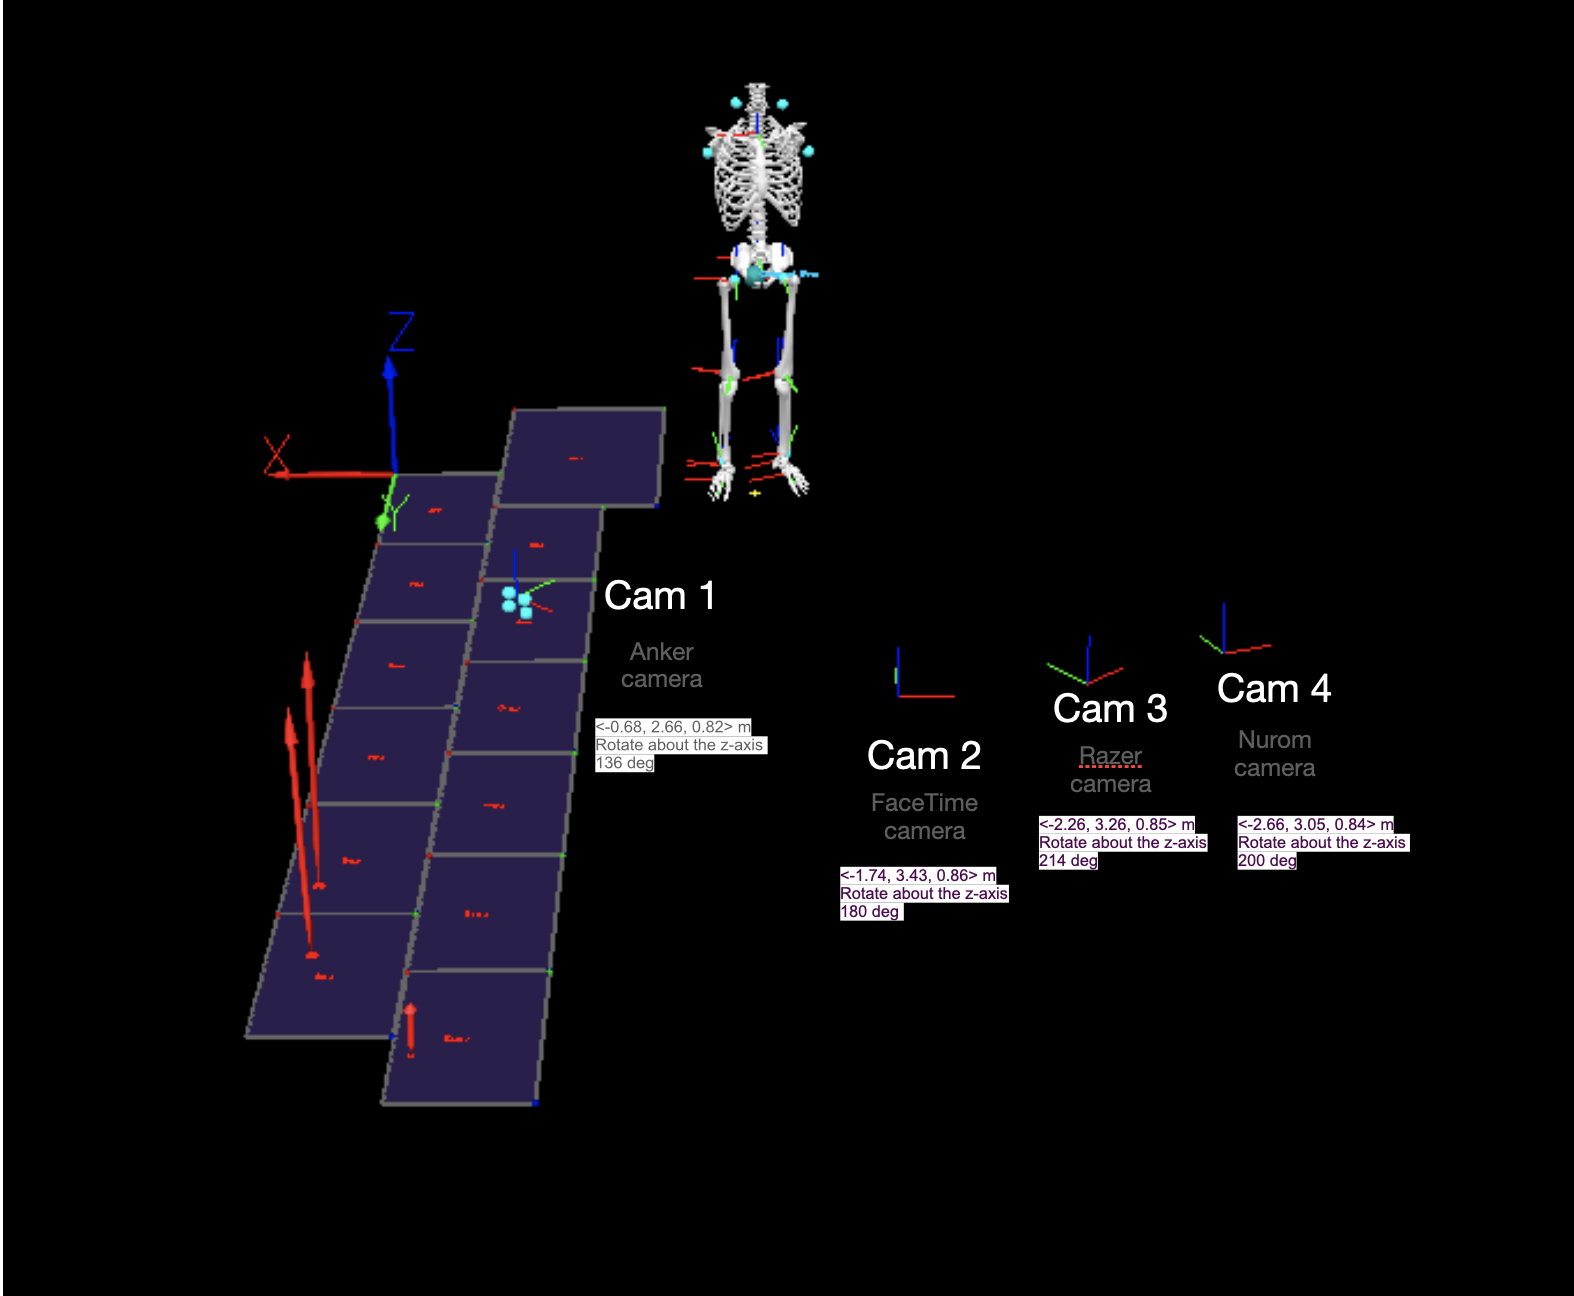

In [ ]:
# todo: write a loss function in jax and optimize over the angles
# or even over multiple points -- demand a fixed set of angles that works for all of them 

<ipython-input-12-8e4d004583f0>:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


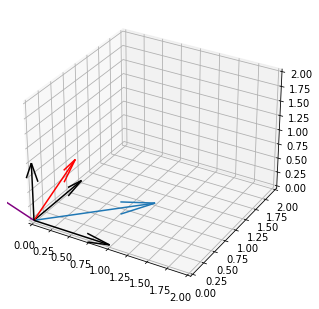

In [12]:
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

a_test=45
z_rot_test = np.array([[np.cos(a_test), -np.sin(a_test), 0],
                  [np.sin(a_test), np.cos(a_test), 0],
                  [0, 0, 1.0]])

# creating figure
fig = plt.figure()
ax = Axes3D(fig)

test_vec = np.array([1, 1, 0])
rot_vec = np.matmul(z_rot_test, test_vec)
rot_vec2 = np.matmul(z_rot_test, rot_vec)

ax.quiver(0,0,0, 1,0,0, color='black')
ax.quiver(0,0,0, 0,1,0, color='black')
ax.quiver(0,0,0, 0,0,1, color='black')

ax.quiver(0,0,0, test_vec[0], test_vec[1], test_vec[2])
ax.quiver(0,0,0, rot_vec[0], rot_vec[1], rot_vec[2], color='red')
ax.quiver(0,0,0, rot_vec2[0], rot_vec2[1], rot_vec2[2], color='purple')
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.set_zlim(0,2)
plt.show()

In [13]:
mcl_keypoints = ['LEFT_ANKLE', 'LEFT_EAR', 'LEFT_SHOULDER', 'LEFT_HIP',
                'LEFT_KNEE', 'RIGHT_ANKLE', 'RIGHT_EAR', 'RIGHT_SHOULDER', 
                 'RIGHT_HIP', 'RIGHT_KNEE', 'COM']

In [14]:
# read in MCL datasets
# mcl_data = '../mcl experiments/mcl data/MCL_4_14/Global Points & CoM.txt'
mcl_data = '../mcl experiments/mcl data/MCL_4_14/3d_MCL_points.csv'
mcl_kp_df = pd.read_csv(mcl_data)

In [15]:
def make_3d_kps(df):
    for var in mcl_keypoints:
        df[var] = df.apply(lambda row: [row[f'{var}_X'], row[f'{var}_Y'], row[f'{var}_Z']], axis=1)
        del df[f'{var}_X']
        del df[f'{var}_Y']
        del df[f'{var}_Z'] 
    del df['ITEM']

for var in mcl_keypoints:
#     var = 'LEFT_ANKLE'
    mcl_kp_df[var] = mcl_kp_df.apply(lambda row: [row[f'{var}_X'], row[f'{var}_Y'], row[f'{var}_Z']], axis=1)
    del mcl_kp_df[f'{var}_X']
    del mcl_kp_df[f'{var}_Y']
    del mcl_kp_df[f'{var}_Z']
del mcl_kp_df['ITEM']

In [ ]:
# def add_time_to_df(df, time_interval):
#     time_arr = np.linspace(time_interval[0], time_interval[1], num=len(df))
#     df['time_int'] = time_arr
#     df['time'] = time_arr
    
#     return df

In [19]:
def add_xyz(df):
    for var in mcl_keypoints:
        df[f'{var}_X'] = df.apply(lambda row: row[var][0], axis=1)
        df[f'{var}_Y'] = df.apply(lambda row: row[var][0], axis=1)
        df[f'{var}_Z'] = df.apply(lambda row: row[var][0], axis=1)
    return df

def rotate_mcl_kps(df, ang, t):
    z_rot = np.array([[np.cos(ang), -np.sin(ang), 0],
                      [np.sin(ang), np.cos(ang), 0],
                      [0, 0, 1.0]])

    for var in mcl_keypoints:
        df[var] = df.apply(lambda row: np.matmul(z_rot,row[var])+t, axis=1)
    
    return add_xyz(df)


def add_times(df, t):
    df['time'] = np.linspace(t[0], t[1], len(df))
    df['time_int'] = np.linspace(t[0], t[1], len(df))
    return df

In [20]:
time_int = [45 + (55./60), 46+(16./60)]

mcl_kp_df = add_times(mcl_kp_df, time_int)

mcl_1 = mcl_kp_df.copy()
mcl_2 = mcl_kp_df.copy()
mcl_3 = mcl_kp_df.copy()
mcl_4 = mcl_kp_df.copy()

c1, c2, c3, c4 = [.68, 2.66, 0.82], [1.74, 3.43, 0.86], [2.26, 3.26, 0.84], [2.66, 3.05, 0.84]
# a1, a2, a3, a4 = (np.pi/180)*45, (np.pi/180)*90, (np.pi/180)*135, (np.pi/180)*180
a1, a2, a3, a4 = (np.pi/180)*136, (np.pi/180)*180, (np.pi/180)*214, (np.pi/180)*200

mcl_1 = rotate_mcl_kps(mcl_1, a1, c1)
mcl_2 = rotate_mcl_kps(mcl_2, a2, c2)
mcl_3 = rotate_mcl_kps(mcl_3, a3, c3)
mcl_4 = rotate_mcl_kps(mcl_4, a4, c4)

# mcl_kp_df = add_xyz(mcl_kp_df)
# mcl_1 = add_xyz(mcl_1)
# mcl_2 = add_xyz(mcl_2)
# mcl_3 = add_xyz(mcl_3)
# mcl_4 = add_xyz(mcl_4)

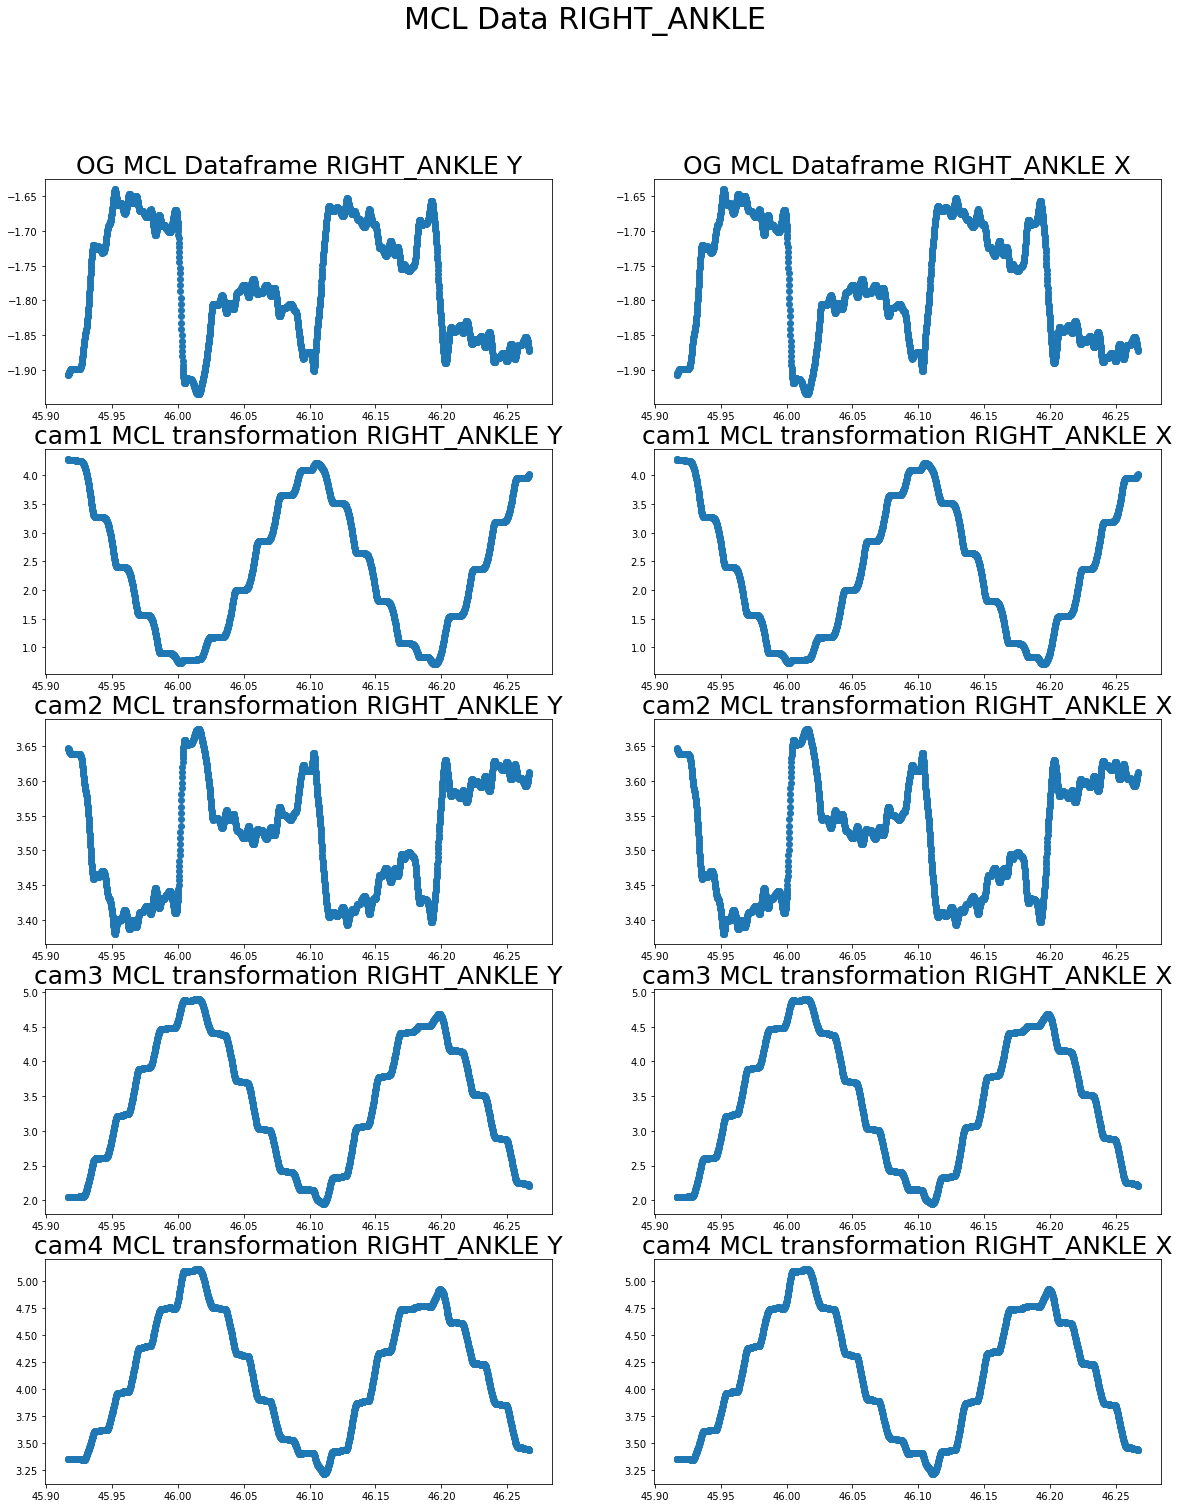

In [26]:
# from matplotlib.ticker import ScalarFormatter
df0 = mcl_kp_df.copy()
df1 = mcl_1.copy()
df2 = mcl_2.copy()
df3 = mcl_3.copy()
df4 = mcl_4.copy()

# df0 = mcl_kp_df.copy()
# df1 = mcl_kp_df.copy()
# df2 = mcl_kp_df.copy()
# df3 = mcl_kp_df.copy()
# df4 = mcl_kp_df.copy()

# df1 = rotate_mcl_kps(df1, 30, [0,0,0])
# df2 = rotate_mcl_kps(df2, 60, [0,0,0])
# df3 = rotate_mcl_kps(df3, 110, [0,0,0])
# df4 = rotate_mcl_kps(df4, 170, [0,0,0])

plot_var = 'RIGHT_ANKLE'

fig5, ax5 = plt.subplots(nrows=5, ncols=2)
fig5.set_size_inches(20, 24)
fig5.suptitle(f"MCL Data {plot_var}", fontsize=30)

# # normalize
# df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
# df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
# df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

ax5[0][1].scatter(df0['time'], df0[f'{plot_var}_X'])
ax5[0][1].set_title(f"OG MCL Dataframe {plot_var} X", fontsize=25)
ax5[0][0].scatter(df0['time'], df0[f'{plot_var}_Y'])
ax5[0][0].set_title(f"OG MCL Dataframe {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df1['time'], df1[f'{plot_var}_X'])
ax5[1][1].set_title(f"cam1 MCL transformation {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df1['time'], df1[f'{plot_var}_Y'])
ax5[1][0].set_title(f"cam1 MCL transformation {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df2['time'], df2[f'{plot_var}_X'])
ax5[2][1].set_title(f"cam2 MCL transformation {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df2['time'], df2[f'{plot_var}_Y'])
ax5[2][0].set_title(f"cam2 MCL transformation {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

ax5[3][1].scatter(df3['time'], df3[f'{plot_var}_X'])
ax5[3][1].set_title(f"cam3 MCL transformation {plot_var} X", fontsize=25)
# ax5[3][1].set_ylim(-300,600)
ax5[3][0].scatter(df3['time'], df3[f'{plot_var}_Y'])
ax5[3][0].set_title(f"cam3 MCL transformation {plot_var} Y", fontsize=25)
# ax5[3][0].set_ylim(0,300)

ax5[4][1].scatter(df4['time'], df4[f'{plot_var}_X'])
ax5[4][1].set_title(f"cam4 MCL transformation {plot_var} X", fontsize=25)
# ax5[4][1].set_ylim(-300,600)
ax5[4][0].scatter(df4['time'], df4[f'{plot_var}_Y'])
ax5[4][0].set_title(f"cam4 MCL transformation {plot_var} Y", fontsize=25)
# ax5[4][0].set_ylim(0,300)

plt.show()

In [27]:
c1_file = '../mcl experiments/coral data/MCL_4_14/cam1_1.csv'
c2_file = '../mcl experiments/coral data/MCL_4_14/cam2_1.csv'
c3_file = '../mcl experiments/coral data/MCL_4_14/cam3_1.csv'
c4_file = '../mcl experiments/coral data/MCL_4_14/cam4_1.csv'

c1_df = create_df_from_file(c1_file)
c2_df = create_df_from_file(c2_file)
c3_df = create_df_from_file(c3_file)
c4_df = create_df_from_file(c4_file)

# add times
# 10:45:55-10:46:16
time_int = [45 + (55./60), 46+(16./60)]

c1_df = add_times(c1_df, time_int)
c2_df = add_times(c2_df, time_int)
c3_df = add_times(c3_df, time_int)
c4_df = add_times(c4_df, time_int)

c1_df = add_com(c1_df.copy())
c2_df = add_com(c2_df.copy())
c3_df = add_com(c3_df.copy())
c4_df = add_com(c4_df.copy())

og_c1_df = c1_df.copy()
og_c2_df = c2_df.copy()
og_c3_df = c3_df.copy()
og_c4_df = c4_df.copy()

../mcl experiments/coral data/MCL_4_14/cam1_1.csv
../mcl experiments/coral data/MCL_4_14/cam2_1.csv
../mcl experiments/coral data/MCL_4_14/cam3_1.csv
../mcl experiments/coral data/MCL_4_14/cam4_1.csv


<ipython-input-5-ca25f44fc403>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clean_coral_df[f'{kp}_X'] = clean_coral_df.apply(lambda row: np.float(row[kp][0]), axis=1)
<ipython-input-5-ca25f44fc403>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clean_coral_df[f'{kp}_Y'] = clean_coral_df.apply(lambda row: np.float(row[kp][1]), axis=1

In [28]:
var1 = 'RIGHT_KNEE_X'
var2 = 'RIGHT_KNEE_Y'

test_df = test_df[test_df[var1]>150]
test_df = test_df[test_df[var2]>300]

plt.scatter(test_df['time_int'], test_df[var1])
plt.title(f'{var1}')
plt.show()
var = 'RIGHT_KNEE_Y'
plt.scatter(test_df['time_int'], test_df[var2])
plt.title(f'{var}')
plt.show()

NameError: name 'test_df' is not defined

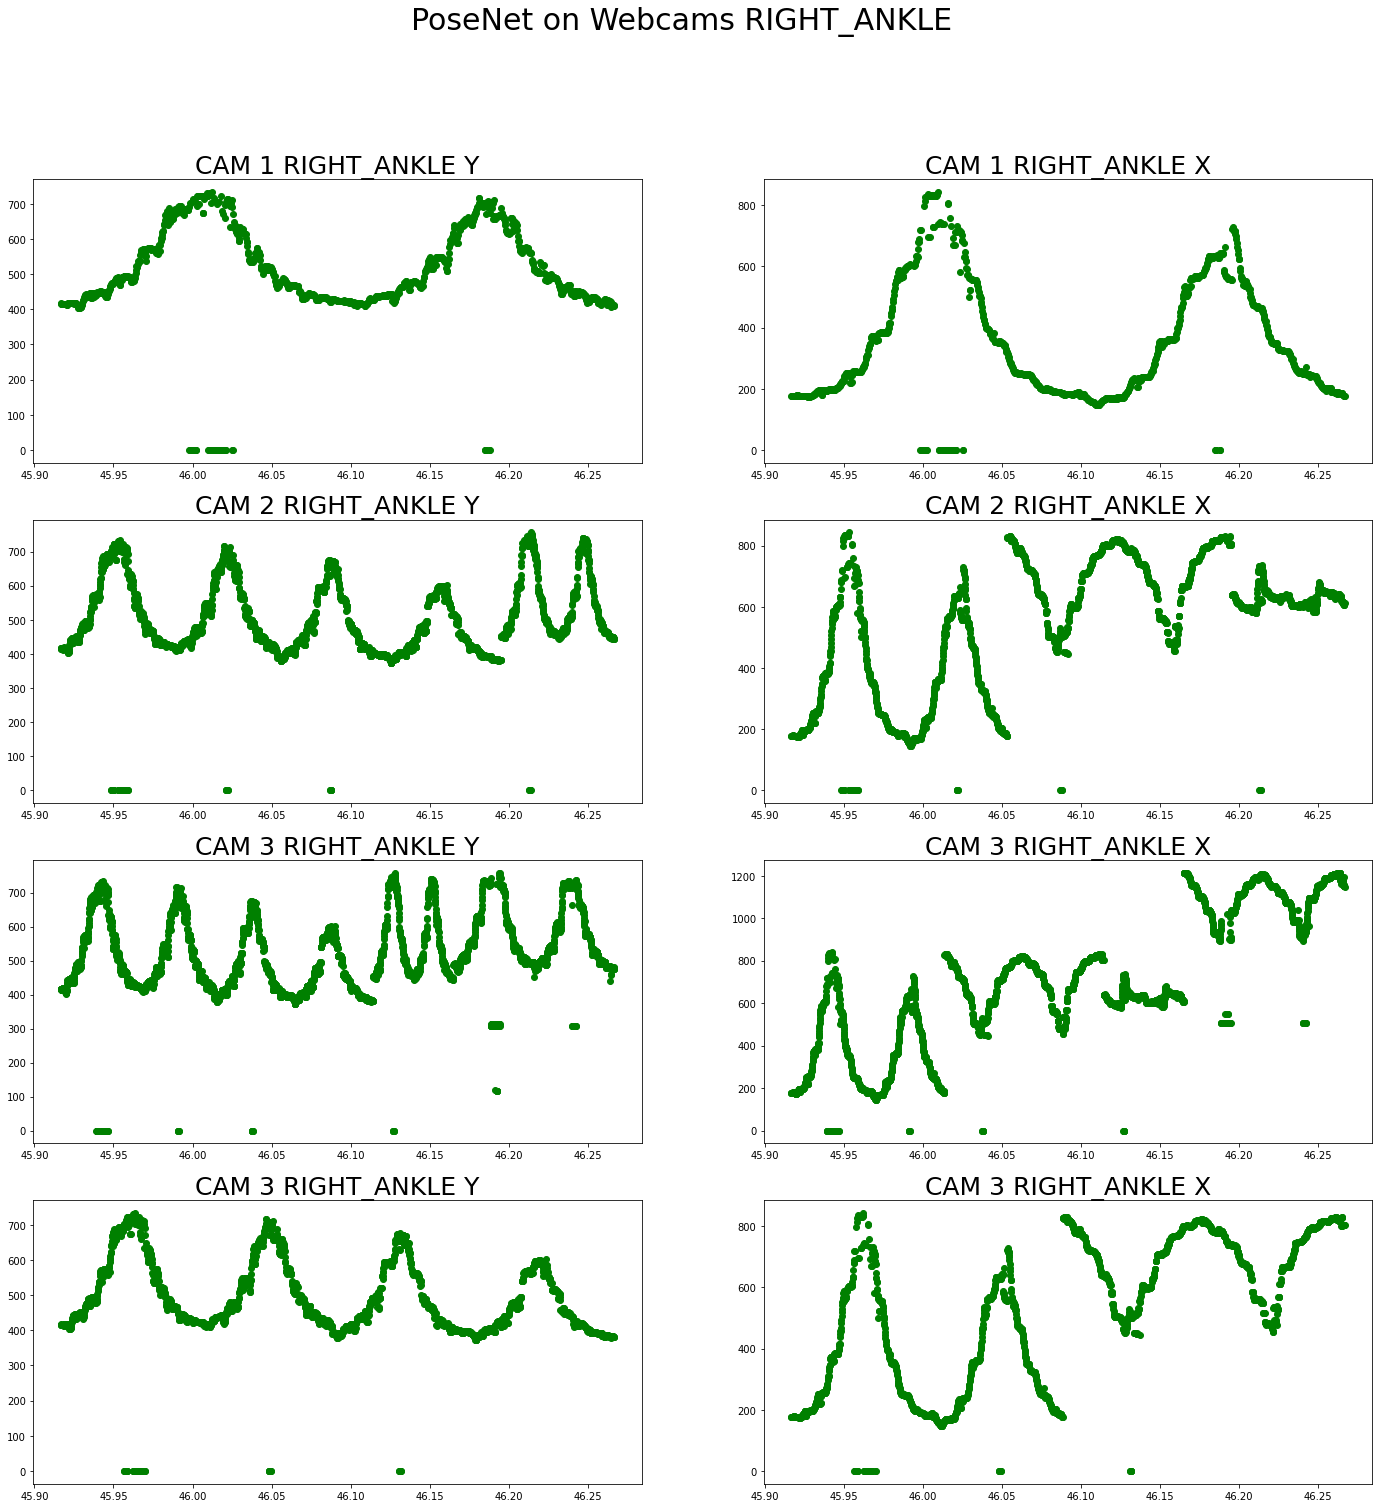

In [ ]:
# from matplotlib.ticker import ScalarFormatter
plot_var = 'RIGHT_ANKLE'

# # front walk
# df1 = df1[df1['time_int']<time1]
# df2 = df2[df2['time_int']<time1]
# df3 = df3[df3['time_int']<time1]

fig5, ax5 = plt.subplots(nrows=4, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"PoseNet on Webcams {plot_var}", fontsize=30)

df1 = c1_df.copy()
df2 = c2_df.copy()
df3 = c3_df.copy()
df4 = c4_df.copy()

# # normalize
# df1 = normalize_df(df1, f'{plot_var}_X', f'{plot_var}_Y')
# df2 = normalize_df(df2, f'{plot_var}_X', f'{plot_var}_Y')
# df3 = normalize_df(df3, f'{plot_var}_X', f'{plot_var}_Y')

ax5[0][1].scatter(df1['time_int'], df1[f'{plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].scatter(df1['time_int'], df1[f'{plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time_int'], df2[f'{plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time_int'], df2[f'{plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time_int'], df3[f'{plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time_int'], df3[f'{plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

ax5[3][1].scatter(df4['time_int'], df4[f'{plot_var}_X'], color='green')
ax5[3][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[3][0].scatter(df4['time_int'], df4[f'{plot_var}_Y'], color='green')
ax5[3][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

In [ ]:
# manually filter the values sigh:
c1_df = c1_df[c1_df[f'{plot_var}_X']>200]
c1_df = c1_df[c1_df[f'{plot_var}_Y']>100]

c2_df = c2_df[c2_df[f'{plot_var}_X']>200]
c2_df = c2_df[c2_df[f'{plot_var}_Y']>50]

c3_df = c3_df[c3_df[f'{plot_var}_X']>200]
c3_df = c3_df[c3_df[f'{plot_var}_Y']>50]

c4_df = c4_df[c4_df[f'{plot_var}_X']>200]
c4_df = c4_df[c4_df[f'{plot_var}_Y']>50]

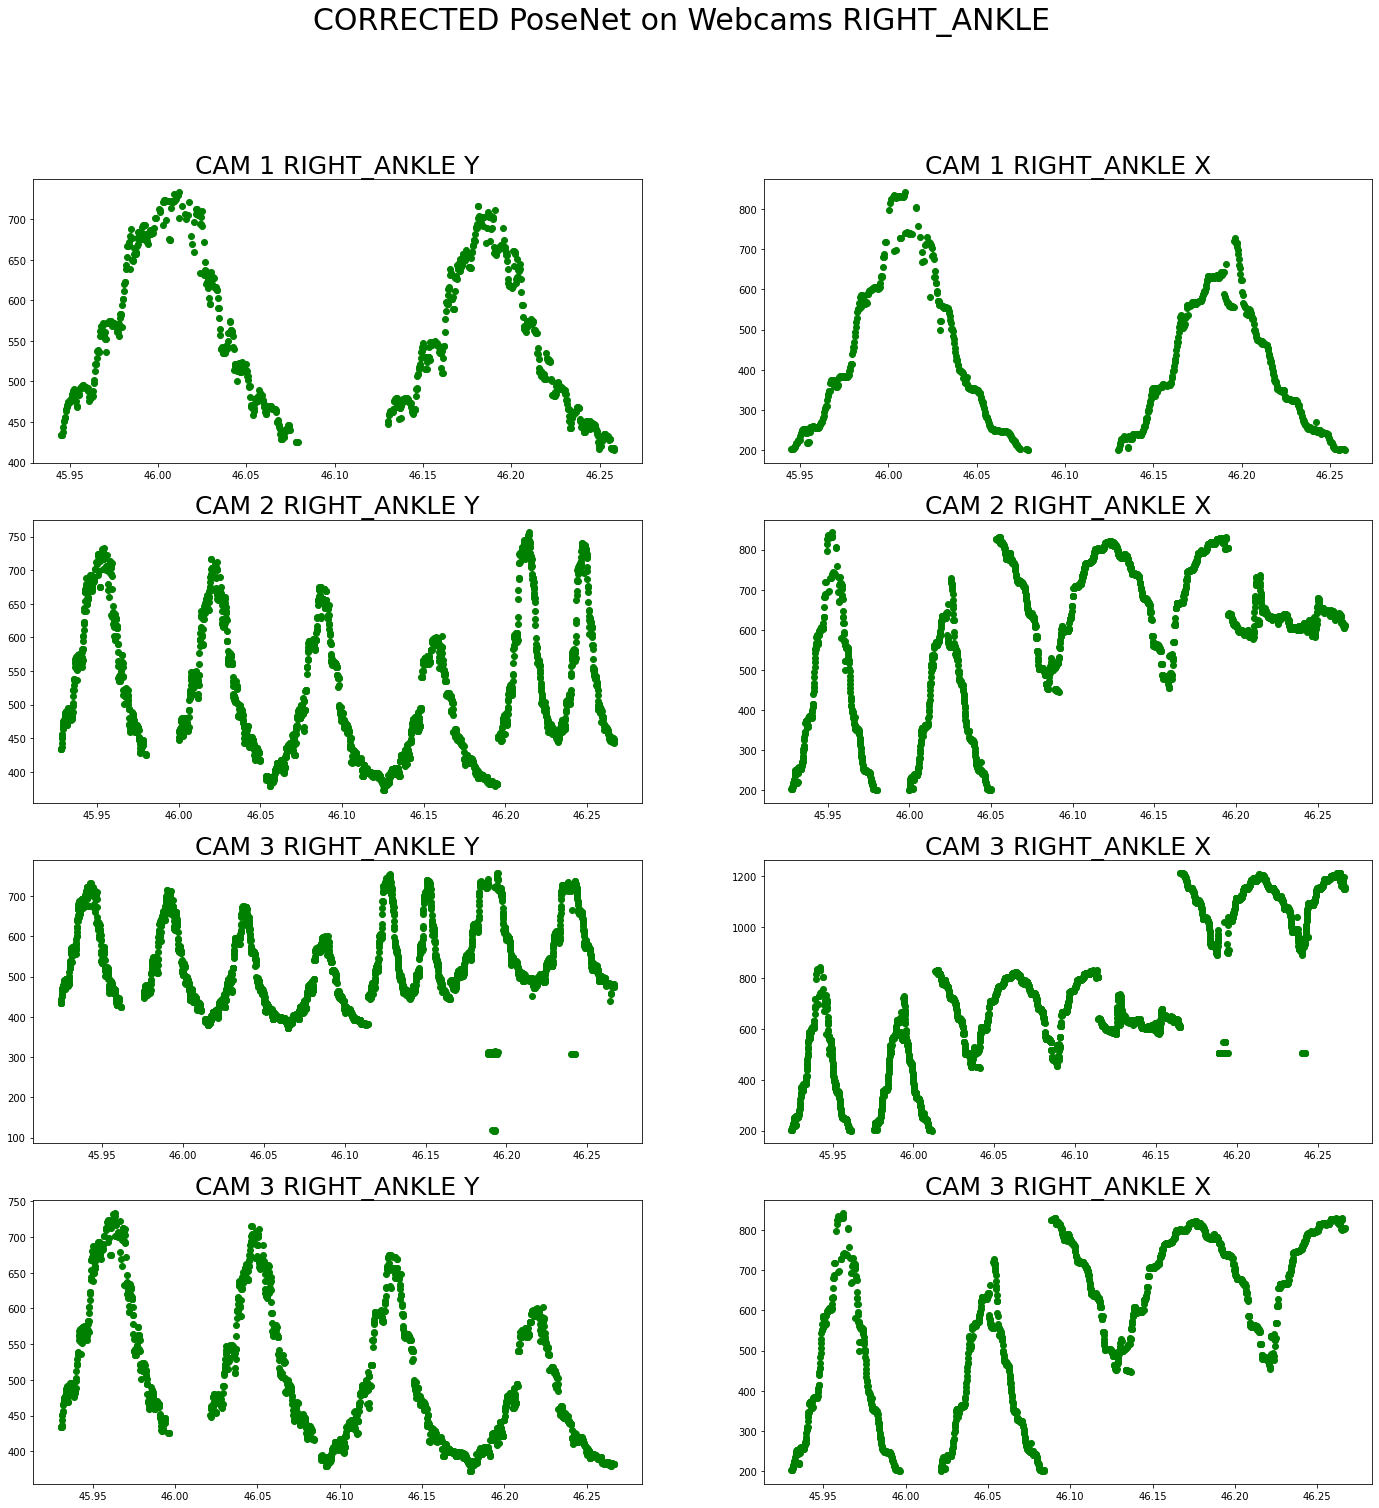

In [ ]:
# from matplotlib.ticker import ScalarFormatter
plot_var = 'RIGHT_ANKLE'

# # front walk
# df1 = df1[df1['time_int']<time1]
# df2 = df2[df2['time_int']<time1]
# df3 = df3[df3['time_int']<time1]

fig5, ax5 = plt.subplots(nrows=4, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"CORRECTED PoseNet on Webcams {plot_var}", fontsize=30)

df1 = c1_df.copy()
df2 = c2_df.copy()
df3 = c3_df.copy()
df4 = c4_df.copy()

# # normalize
# df1 = normalize_df(df1, f'{plot_var}_X', f'{plot_var}_Y')
# df2 = normalize_df(df2, f'{plot_var}_X', f'{plot_var}_Y')
# df3 = normalize_df(df3, f'{plot_var}_X', f'{plot_var}_Y')

ax5[0][1].scatter(df1['time_int'], df1[f'{plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].scatter(df1['time_int'], df1[f'{plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time_int'], df2[f'{plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time_int'], df2[f'{plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time_int'], df3[f'{plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time_int'], df3[f'{plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

ax5[3][1].scatter(df4['time_int'], df4[f'{plot_var}_X'], color='green')
ax5[3][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[3][0].scatter(df4['time_int'], df4[f'{plot_var}_Y'], color='green')
ax5[3][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

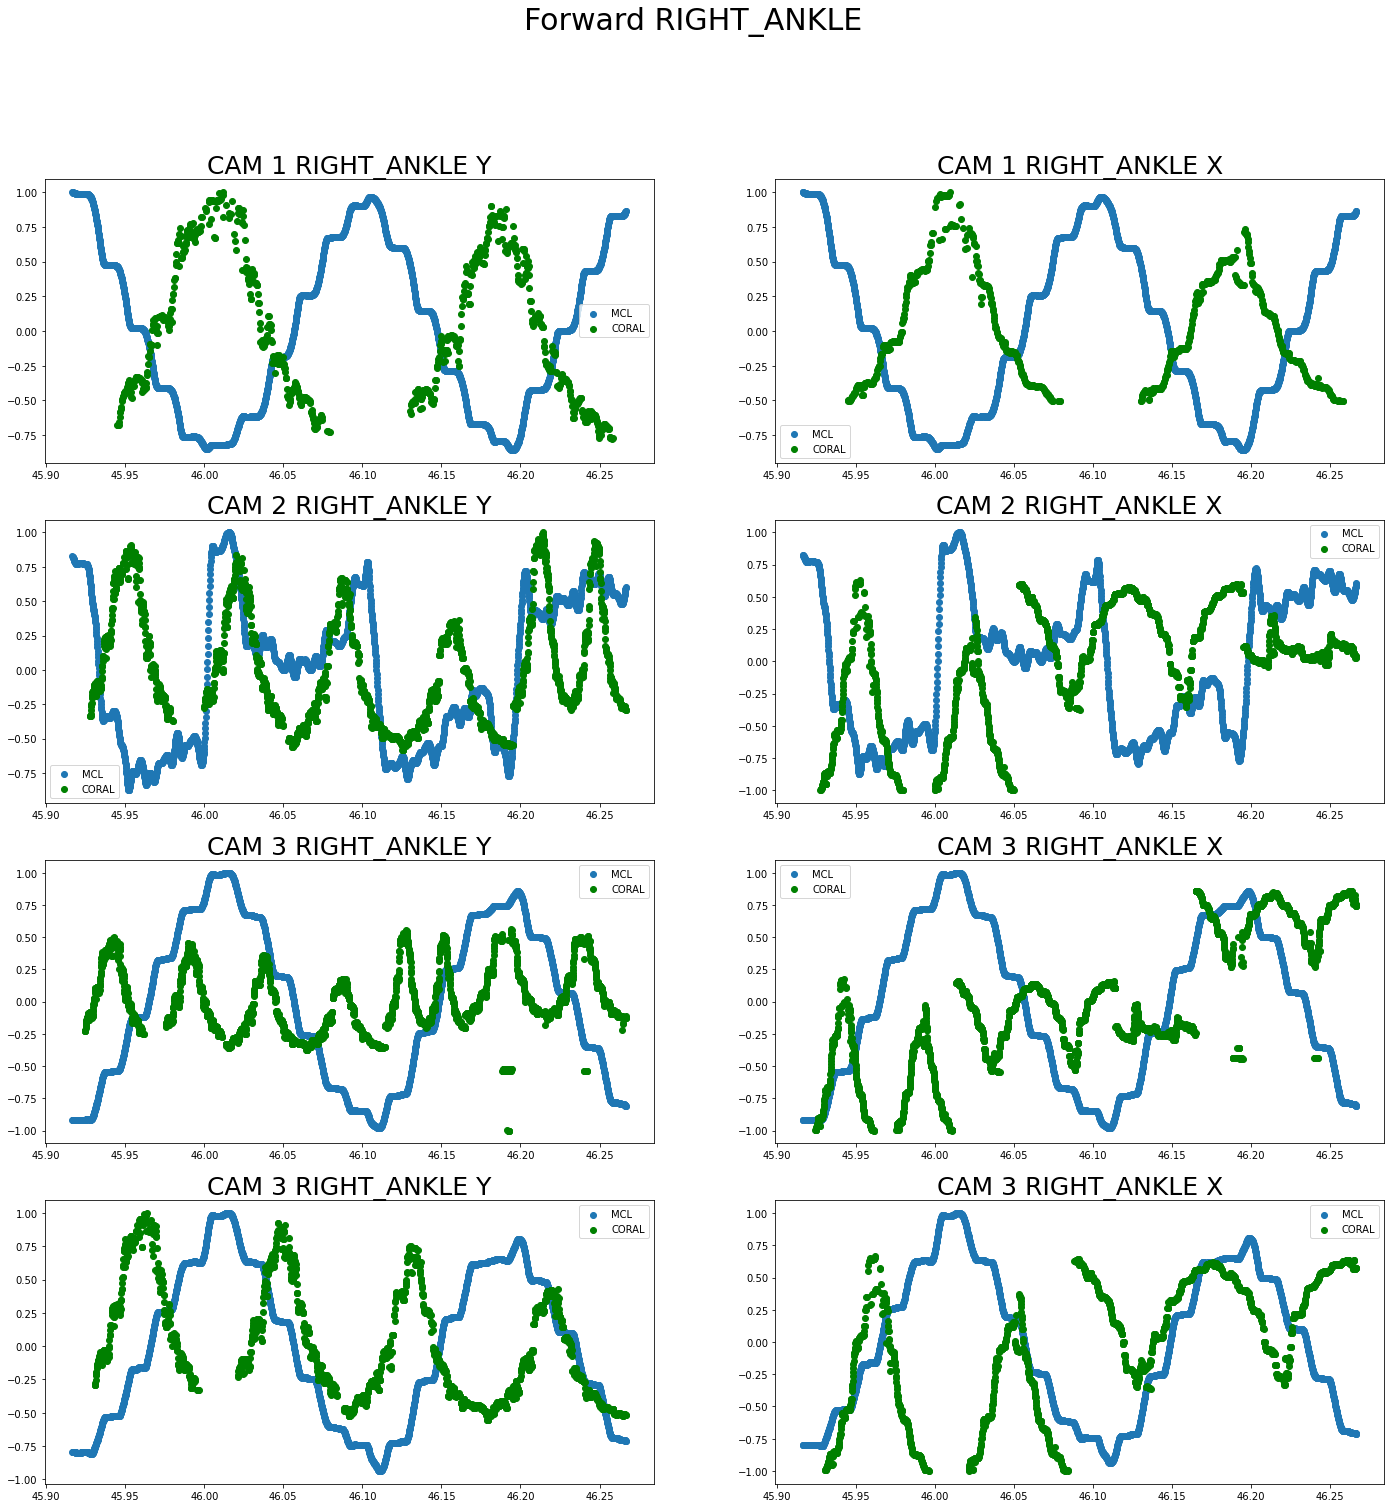

In [ ]:
# time0, time1 = 11.17, 11.21

# from matplotlib.ticker import ScalarFormatter
plot_var = 'RIGHT_ANKLE'
coral_plot_var = 'RIGHT_ANKLE'

df1 = mcl_1.copy()
df2 = mcl_2.copy()
df3 = mcl_3.copy()
df4 = mcl_4.copy()

coral_df1 = c1_df.copy()
coral_df2 = c2_df.copy()
coral_df3 = c3_df.copy()
coral_df4 = c4_df.copy()

fig5, ax5 = plt.subplots(nrows=4, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Forward {plot_var}", fontsize=30)

# normalize
df1 = normalize_df(df1, f'{plot_var}_X', f'{plot_var}_Y')
df2 = normalize_df(df2, f'{plot_var}_X', f'{plot_var}_Y')
df3 = normalize_df(df3, f'{plot_var}_X', f'{plot_var}_Y')
df4 = normalize_df(df4, f'{plot_var}_X', f'{plot_var}_Y')

coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df4 = normalize_df(coral_df4, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

ax5[0][1].scatter(df1['time_int'], df1[f'{plot_var}_X'], label='MCL')
ax5[0][1].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_X'], color='green', label='CORAL')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][1].legend()
ax5[0][0].scatter(df1['time_int'], df1[f'{plot_var}_Y'], label='MCL')
ax5[0][0].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_Y'], color='green', label='CORAL')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)
ax5[0][0].legend()

ax5[1][1].scatter(df2['time_int'], df2[f'{plot_var}_X'], label='MCL')
ax5[1][1].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_X'], color='green', label='CORAL')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
ax5[1][1].legend()
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time_int'], df2[f'{plot_var}_Y'], label='MCL')
ax5[1][0].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_Y'], color='green', label='CORAL')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
ax5[1][0].legend()
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time_int'], df3[f'{plot_var}_X'], label='MCL')
ax5[2][1].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_X'], color='green', label='CORAL')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
ax5[2][1].legend()
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time_int'], df3[f'{plot_var}_Y'], label='MCL')
ax5[2][0].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_Y'], color='green', label='CORAL')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
ax5[2][0].legend()
# ax5[2][0].set_ylim(0,300)

ax5[3][1].scatter(df4['time_int'], df4[f'{plot_var}_X'], label='MCL')
ax5[3][1].scatter(coral_df4['time_int'], coral_df4[f'{coral_plot_var}_X'], color='green', label='CORAL')
ax5[3][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
ax5[3][1].legend()
# ax5[2][1].set_ylim(-300,600)
ax5[3][0].scatter(df4['time_int'], df4[f'{plot_var}_Y'], label='MCL')
ax5[3][0].scatter(coral_df4['time_int'], coral_df4[f'{coral_plot_var}_Y'], color='green', label='CORAL')
ax5[3][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
ax5[3][0].legend()
# ax5[2][0].set_ylim(0,300)

plt.show()

In [ ]:
def interp_df2(mcl_df, coral_df, coral_plot_var, plot_var):
    mcl_df1 = pd.DataFrame(columns=[f'{coral_plot_var}_X', 'time'], index=coral_df['time_int'].to_numpy())
    mcl_df1 = pd.DataFrame(columns=[f'{coral_plot_var}_Y', 'time'], index=coral_df['time_int'].to_numpy())
    mcl_df1[f'{coral_plot_var}_X'] = np.interp(mcl_df1.index, mcl_df['time'], mcl_df[f'{plot_var}_X'])
    mcl_df1[f'{coral_plot_var}_Y'] = np.interp(mcl_df1.index, mcl_df['time'], mcl_df[f'{plot_var}_Y'])
    mcl_df1['time'] = mcl_df1.index
    
    return mcl_df1

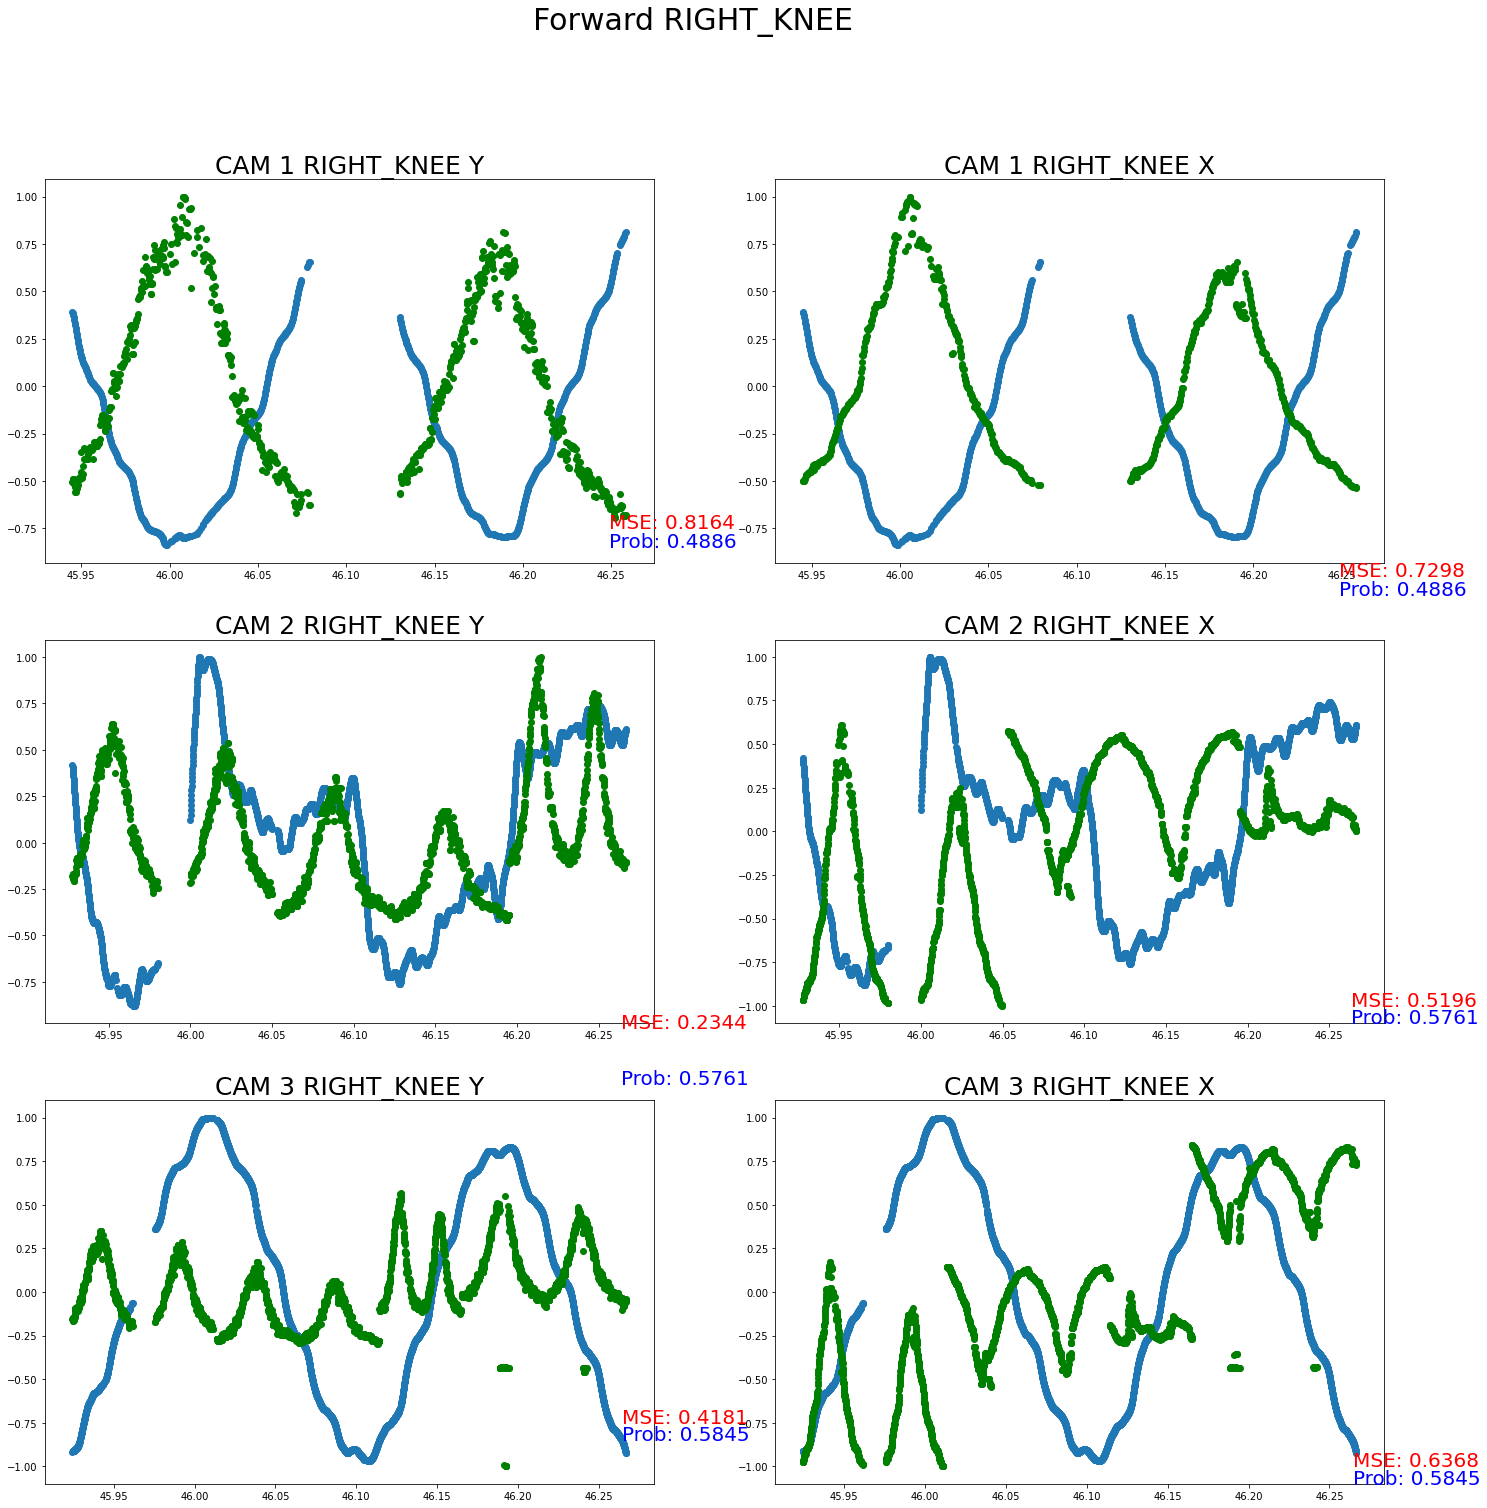

In [ ]:
# from matplotlib.ticker import ScalarFormatter
plot_var = 'RIGHT_KNEE'
coral_plot_var = 'RIGHT_KNEE'

fig5, ax5 = plt.subplots(nrows=3, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"Forward {plot_var}", fontsize=30)

# normalize
df1 = normalize_df(df1, f'{plot_var}_X', f'{plot_var}_Y')
df2 = normalize_df(df2, f'{plot_var}_X', f'{plot_var}_Y')
df3 = normalize_df(df3, f'{plot_var}_X', f'{plot_var}_Y')

coral_df1 = normalize_df(coral_df1, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df2 = normalize_df(coral_df2, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')
coral_df3 = normalize_df(coral_df3, f'{coral_plot_var}_X', f'{coral_plot_var}_Y')

mcl_df1 = interp_df2(df1, coral_df1, coral_plot_var, plot_var)
mcl_df2 = interp_df2(df2, coral_df2, coral_plot_var, plot_var)
mcl_df3 = interp_df2(df3, coral_df3, coral_plot_var, plot_var)

mse1 = calculate_mse(coral_df1, mcl_df1, coral_plot_var)
mse2 = calculate_mse(coral_df2, mcl_df2, coral_plot_var)
mse3 = calculate_mse(coral_df3, mcl_df3, coral_plot_var)

ax5[0][1].scatter(mcl_df1['time'], mcl_df1[f'{coral_plot_var}_X'])
ax5[0][1].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][1].text(coral_df1['time_int'].iloc[-30], -1.0, f"MSE: {round(mse1[0],4)}", fontsize=20, color='red')
ax5[0][1].text(coral_df1['time_int'].iloc[-30], -1.1, f"Prob: {round(mse1[2],4)}", fontsize=20, color='blue')

ax5[0][0].scatter(mcl_df1['time'], mcl_df1[f'{coral_plot_var}_Y'])
ax5[0][0].scatter(coral_df1['time_int'], coral_df1[f'{coral_plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)
ax5[0][0].text(coral_df1['time_int'].iloc[-30], -.75, f"MSE: {round(mse1[1],4)}", fontsize=20, color='red')
ax5[0][0].text(coral_df1['time_int'].iloc[-30], -.85, f"Prob: {round(mse1[2],4)}", fontsize=20, color='blue')

ax5[1][1].scatter(mcl_df2['time'], mcl_df2[f'{coral_plot_var}_X'])
ax5[1][1].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
ax5[1][1].text(coral_df2['time_int'].iloc[-30], -1.0, f"MSE: {round(mse2[0],4)}", fontsize=20, color='red')
ax5[1][1].text(coral_df2['time_int'].iloc[-30], -1.1, f"Prob: {round(mse2[2],4)}", fontsize=20, color='blue')

ax5[1][0].scatter(mcl_df2['time'], mcl_df2[f'{coral_plot_var}_Y'])
ax5[1][0].scatter(coral_df2['time_int'], coral_df2[f'{coral_plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
ax5[1][0].text(coral_df2['time_int'].iloc[-30], -1.0, f"MSE: {round(mse2[1],4)}", fontsize=20, color='red')
ax5[1][0].text(coral_df2['time_int'].iloc[-30], -1.3, f"Prob: {round(mse2[2],4)}", fontsize=20, color='blue')

ax5[2][1].scatter(mcl_df3['time'], mcl_df3[f'{coral_plot_var}_X'])
ax5[2][1].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
ax5[2][1].text(coral_df3['time_int'].iloc[-30], -1.0, f"MSE: {round(mse3[0],4)}", fontsize=20, color='red')
ax5[2][1].text(coral_df3['time_int'].iloc[-30], -1.1, f"Prob: {round(mse3[2],4)}", fontsize=20, color='blue')

ax5[2][0].scatter(mcl_df3['time'], mcl_df3[f'{coral_plot_var}_Y'])
ax5[2][0].scatter(coral_df3['time_int'], coral_df3[f'{coral_plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
ax5[2][0].text(coral_df3['time_int'].iloc[-30], -0.75, f"MSE: {round(mse3[1],4)}", fontsize=20, color='red')
ax5[2][0].text(coral_df3['time_int'].iloc[-30], -.85, f"Prob: {round(mse3[2],4)}", fontsize=20, color='blue')

plt.show()

## Spatiotemporal Params

In [72]:
# import os
# os.listdir('../mcl experiments/coral data/MCL_4_14')

In [75]:
c1_file_2 = '../mcl experiments/coral data/MCL_4_14/cam1_2_df.csv'
c2_file_2 = '../mcl experiments/coral data/MCL_4_14/cam2_2_df.csv'
c3_file_2 = '../mcl experiments/coral data/MCL_4_14/cam3_2_df.csv'
c4_file_2 = '../mcl experiments/coral data/MCL_4_14/cam4_2_df.csv'

c1_2 = create_df_from_file(c1_file_2)
c2_2 = create_df_from_file(c2_file_2)
c3_2 = create_df_from_file(c3_file_2)
c4_2 = create_df_from_file(c4_file_2)

time_int = [51 + (40./60), 51 + (48./60)]

c1_2 = add_com(add_times(c1_2, time_int))
c2_2 = add_com(add_times(c2_2, time_int))
c3_2 = add_com(add_times(c3_2, time_int))
c4_2 = add_com(add_times(c4_2, time_int))

../mcl experiments/coral data/MCL_4_14/cam1_2_df.csv
../mcl experiments/coral data/MCL_4_14/cam2_2_df.csv
../mcl experiments/coral data/MCL_4_14/cam3_2_df.csv
../mcl experiments/coral data/MCL_4_14/cam4_2_df.csv


<ipython-input-5-ca25f44fc403>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clean_coral_df[f'{kp}_X'] = clean_coral_df.apply(lambda row: np.float(row[kp][0]), axis=1)
<ipython-input-5-ca25f44fc403>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clean_coral_df[f'{kp}_Y'] = clean_coral_df.apply(lambda row: np.float(row[kp][1]), axis=1

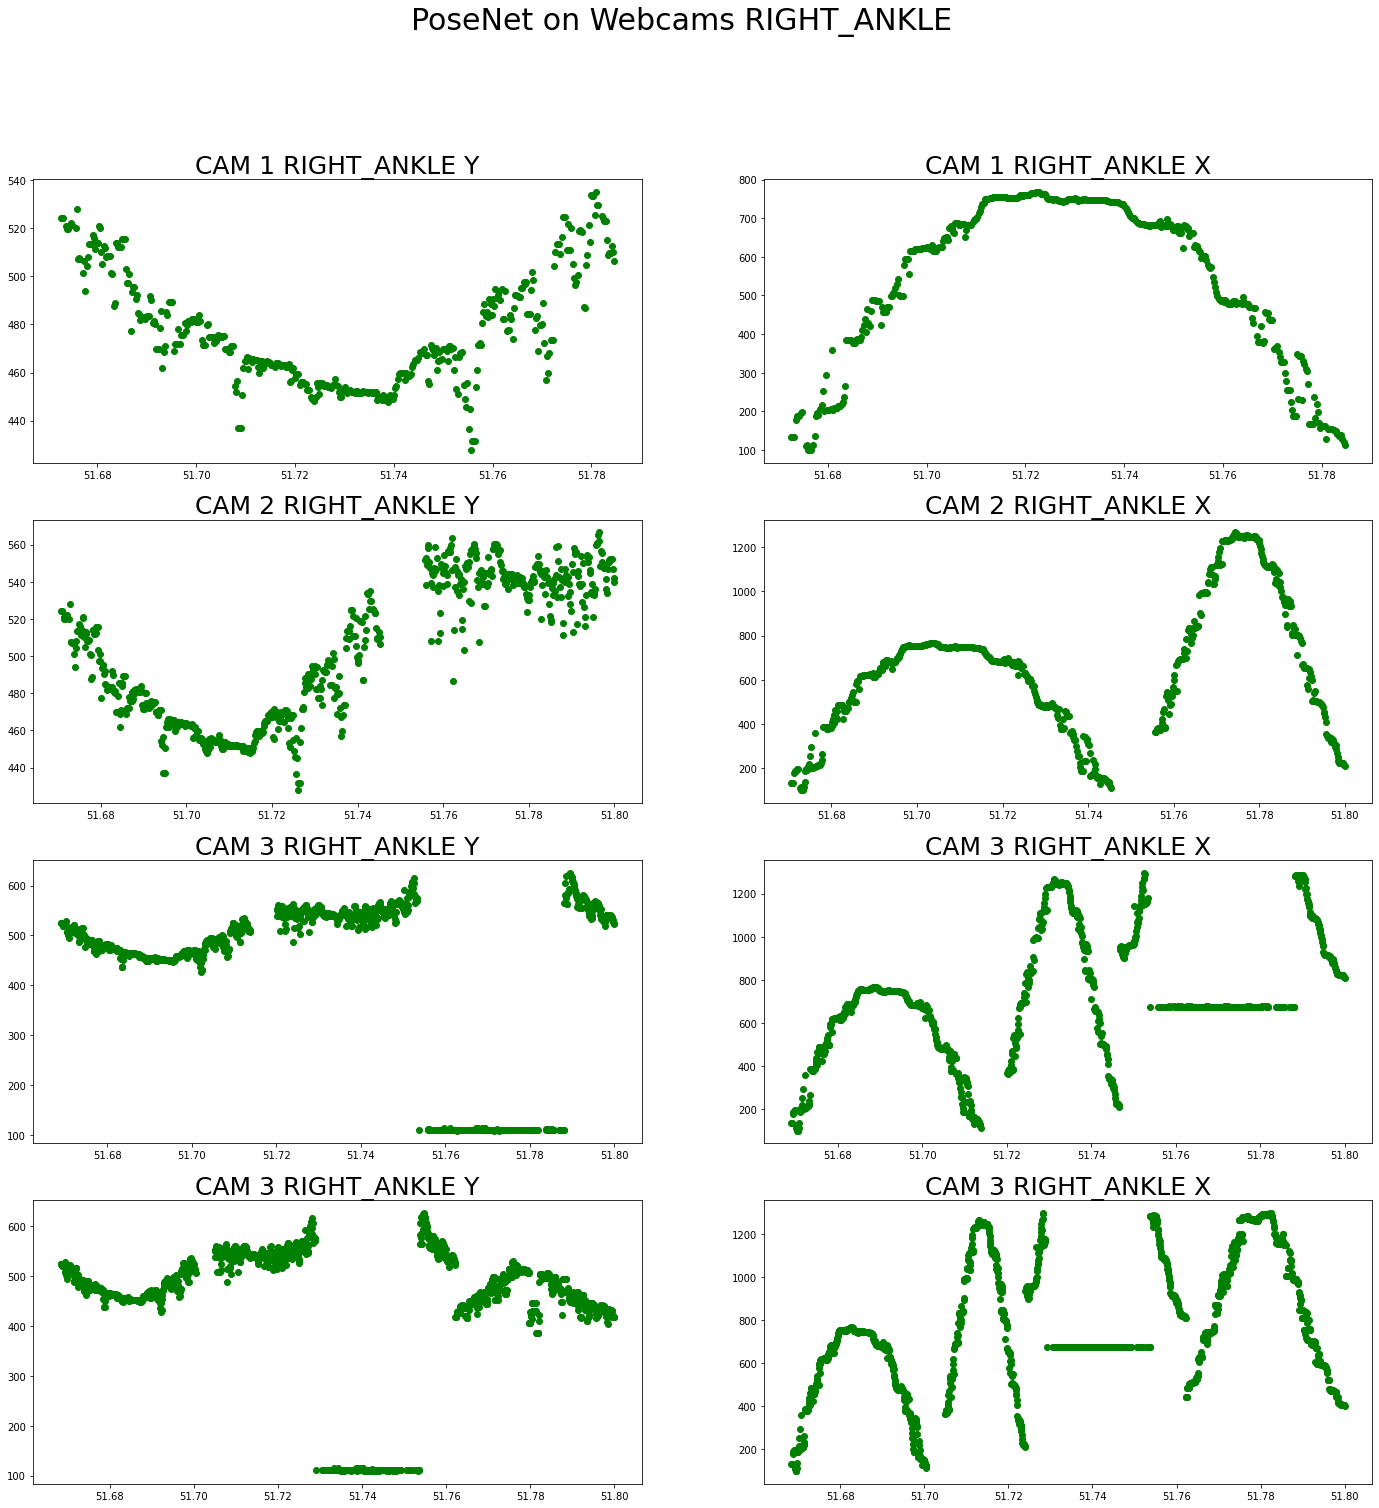

In [80]:
# from matplotlib.ticker import ScalarFormatter
plot_var = 'RIGHT_ANKLE'

# # front walk
# df1 = df1[df1['time_int']<time1]
# df2 = df2[df2['time_int']<time1]
# df3 = df3[df3['time_int']<time1]

fig5, ax5 = plt.subplots(nrows=4, ncols=2)
fig5.set_size_inches(24, 24)
fig5.suptitle(f"PoseNet on Webcams {plot_var}", fontsize=30)

df1 = c1_2.copy()
df2 = c2_2.copy()
df3 = c3_2.copy()
df4 = c4_2.copy()

df1 = df1[df1[f'{plot_var}_X']>100]
df2 = df2[df2[f'{plot_var}_X']>100]
df3 = df3[df3[f'{plot_var}_X']>100]
df4 = df4[df4[f'{plot_var}_X']>100]

# # normalize
# df1 = normalize_df(df1, f'{plot_var}_X', f'{plot_var}_Y')
# df2 = normalize_df(df2, f'{plot_var}_X', f'{plot_var}_Y')
# df3 = normalize_df(df3, f'{plot_var}_X', f'{plot_var}_Y')

ax5[0][1].scatter(df1['time_int'], df1[f'{plot_var}_X'], color='green')
ax5[0][1].set_title(f"CAM 1 {plot_var} X", fontsize=25)
ax5[0][0].scatter(df1['time_int'], df1[f'{plot_var}_Y'], color='green')
ax5[0][0].set_title(f"CAM 1 {plot_var} Y", fontsize=25)

ax5[1][1].scatter(df2['time_int'], df2[f'{plot_var}_X'], color='green')
ax5[1][1].set_title(f"CAM 2 {plot_var} X", fontsize=25)
# ax5[1][1].set_ylim(-300,600)
ax5[1][0].scatter(df2['time_int'], df2[f'{plot_var}_Y'], color='green')
ax5[1][0].set_title(f"CAM 2 {plot_var} Y", fontsize=25)
# ax5[1][0].set_ylim(1,600)

ax5[2][1].scatter(df3['time_int'], df3[f'{plot_var}_X'], color='green')
ax5[2][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[2][0].scatter(df3['time_int'], df3[f'{plot_var}_Y'], color='green')
ax5[2][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

ax5[3][1].scatter(df4['time_int'], df4[f'{plot_var}_X'], color='green')
ax5[3][1].set_title(f"CAM 3 {plot_var} X", fontsize=25)
# ax5[2][1].set_ylim(-300,600)
ax5[3][0].scatter(df4['time_int'], df4[f'{plot_var}_Y'], color='green')
ax5[3][0].set_title(f"CAM 3 {plot_var} Y", fontsize=25)
# ax5[2][0].set_ylim(0,300)

plt.show()

0.8749181707659073  seconds
0.8803189002150822  seconds


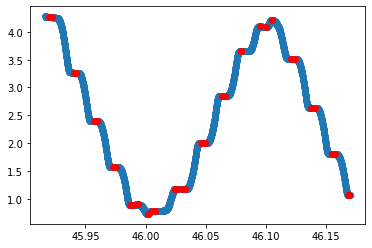

0.0649060911071909  seconds
0.06758270191780469  seconds


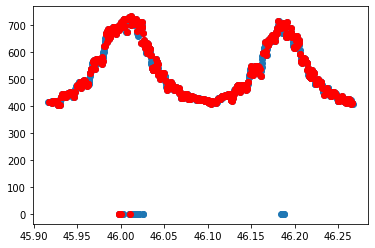

In [64]:
from scipy.signal import argrelextrema

timeseries_df = mcl_1.copy()
# timeseries_df = timeseries_df[timeseries_df['time'] > 46.0]
timeseries_df = timeseries_df[timeseries_df['time'] < 46.17]

def find_timestep(df, var):
    x = df[var].to_numpy()

    # for local maxima
    maxima = argrelextrema(x, np.greater)

    # for local minima
    minima = argrelextrema(x, np.less)

    plt.scatter(df['time'], df[var])

    for m in maxima:
        plt.scatter(df['time'][m], df[var][m], color='red')
        
    for m in minima:
        plt.scatter(df['time'][m], df[var][m], color='red')
        
        
    maxima_times = df.iloc[maxima]['time'].to_numpy()
    minima_times = df.iloc[minima]['time'].to_numpy()

    maxima_diffs = np.diff(maxima_times)
    minima_diffs = np.diff(minima_times)

    print(maxima_diffs.mean()*60, ' seconds')
    print(minima_diffs.mean()*60, ' seconds')
    plt.show()

find_timestep(timeseries_df, 'RIGHT_ANKLE_X')
find_timestep(c1_df.copy(), 'RIGHT_ANKLE_Y')

<ipython-input-40-56eaab5bf303>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


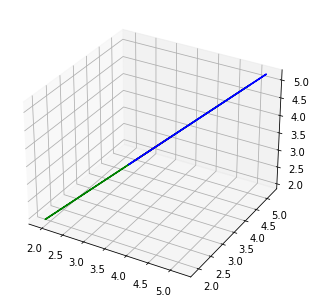

In [40]:
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# creating figure
fig = plt.figure()
ax = Axes3D(fig)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot(mcl_kp_df['RIGHT_SHOULDER_X'], 
#            mcl_kp_df['RIGHT_SHOULDER_Y'], 
#            mcl_kp_df['RIGHT_SHOULDER_Z'], 
#            c='green')
# ax.plot(mcl_1['RIGHT_SHOULDER_X'], 
#            mcl_1['RIGHT_SHOULDER_Y'], 
#            mcl_1['RIGHT_SHOULDER_Z'], 
#            c='blue')
ax.plot(xs=mcl_2['RIGHT_SHOULDER_X'],
        ys=mcl_2['RIGHT_SHOULDER_Y'],
        zs=mcl_2['RIGHT_SHOULDER_Z'],
        c='red')
ax.plot(xs=mcl_3['RIGHT_SHOULDER_X'],
        ys=mcl_3['RIGHT_SHOULDER_Y'],
        zs=mcl_3['RIGHT_SHOULDER_Z'],
        c='green')
ax.plot(xs=mcl_4['RIGHT_SHOULDER_X'],
        ys=mcl_4['RIGHT_SHOULDER_Y'],
        zs=mcl_4['RIGHT_SHOULDER_Z'],
        c='blue')
# ax.plot3D(mcl_4['RIGHT_SHOULDER_X'], 
#            mcl_4['RIGHT_SHOULDER_Y'], 
#            mcl_4['RIGHT_SHOULDER_Z'], 
#            c='green')
# ax.scatter(mcl_2['RIGHT_SHOULDER_X'], mcl_2['RIGHT_SHOULDER_Y'], mcl_2['RIGHT_SHOULDER_Z'], c='green')
# ax.set_xlim(-3,3)
# ax.set_ylim(-3,3)
# ax.set_zlim(-3,3)
plt.show()


,NOSE,LEFT_EYE,RIGHT_EYE,LEFT_EAR,RIGHT_EAR,LEFT_SHOULDER,RIGHT_SHOULDER,LEFT_ELBOW,RIGHT_ELBOW,LEFT_WRIST,...,RIGHT_THORAX_X,RIGHT_THORAX_Y,THORAX_X,THORAX_Y,HEAD_X,HEAD_Y,TRUNK_X,TRUNK_Y,COM_X,COM_Y
0,"[207.31438528830702, 190.88450935776456, 0.998...","[212.36458962267028, 185.44184135828533, 0.995...","[200.6642192569587, 185.8240414856211, 0.99393...","[218.2064345253342, 190.68365090432346, 0.4608...","[192.4052361898549, 191.22225085508475, 0.8924...","[229.72427737424374, 228.70425918727244, 0.920...","[173.56182685036106, 221.31623256223045, 0.967...","[240.98936535063245, 264.1915756521873, 0.9844...","[156.78219511581528, 253.48876521921358, 0.989...","[248.20397977806644, 296.9232379844549, 0.9532...",...,177.163817,257.767394,199.298833,261.432487,207.314385,190.884509,199.298833,261.432487,199.243735,270.385987
1,"[206.25565921208712, 189.91796009418206, 0.998...","[211.6111780385502, 184.66362438651626, 0.9961...","[199.61062238516053, 184.8554651416456, 0.9940...","[216.62281378836116, 190.7054591608775, 0.4660...","[191.24949161193038, 190.4046546205899, 0.9072...","[228.73305643098044, 229.40665087653596, 0.920...","[177.02080160076966, 221.57409509243482, 0.967...","[239.8214314302181, 266.12598651986514, 0.9822...","[157.09412169028408, 255.15970777704712, 0.988...","[245.99329118334066, 297.0624384569229, 0.9657...",...,177.808207,257.749901,199.147849,261.481585,206.255659,189.917960,199.147849,261.481585,198.868572,270.292713
2,"[204.89312486849568, 188.2284631080998, 0.9978...","[210.10813966940196, 183.1510714717447, 0.9948...","[198.76019539635783, 185.2318854470855, 0.9895...","[215.36643392308255, 189.25556717236395, 0.536...","[189.9732148098257, 189.45889185933234, 0.9285...","[227.4142720492718, 225.02010878511342, 0.9983...","[175.48569589178604, 221.5004792656548, 0.9695...","[238.95378720285743, 265.4335150011039, 0.9824...","[158.2761094199783, 255.43922136626858, 0.9865...","[245.44247581845238, 296.91604011101794, 0.968...",...,176.159583,257.930452,197.873125,260.126678,204.893125,188.228463,197.873125,260.126678,197.754265,269.067040
3,"[204.5342815080534, 186.8610409592458, 0.99756...","[209.19311094619073, 184.22642500159148, 0.995...","[198.06870566970383, 184.2770701076386, 0.9881...","[216.59063239473556, 187.9096210283975, 0.7231...","[188.927380028039, 189.00420991789122, 0.93103...","[225.68426639935078, 223.3300810415768, 0.9985...","[174.90122798827363, 220.98859408692084, 0.976...","[237.19091291822184, 262.77904441717095, 0.978...","[158.1163133298113, 255.26737317959578, 0.9865...","[245.11022777691377, 297.4822645676781, 0.9787...",...,175.789484,257.527378,196.735638,258.871057,204.534282,186.861041,196.735638,258.871057,196.879370,267.645282
4,"[204.04920877282458, 187.41952708293263, 0.997...","[208.21797045574442, 184.36587118077378, 0.995...","[196.95747321885977, 184.4588511727554, 0.9889...","[215.582108627903, 187.5727775986416, 0.720444...","[188.169903959919, 188.89602848957713, 0.92935...","[224.8019717690723, 222.4555637634743, 0.99870...","[173.06901418073954, 220.11126874058652, 0.982...","[234.97201245060012, 260.9535273368084, 0.9751...","[156.78523805902677, 256.42443166195767, 0.987...","[242.45268703344556, 294.2131186391378, 0.7877...",...,175.254870,256.759108,196.010758,257.979131,204.049209,187.419527,196.010758,257.979131,196.317052,266.915291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,"[129.07388774982007, 192.3113234859895, 0.7873...","[131.5080257656982, 182.0930574075855, 0.86072...","[129.4042138509877, 182.89570315039603, 0.1999...","[140.48842085422154, 184.13681823899776, 0.982...","[137.64042469414764, 185.90898648710422, 0.034...","[131.0919499155323, 215.95004458698585, 0.9928...","[180.69246314448552, 216.95627262787414, 0.985...","[121.40254310292252, 259.77773785425785, 0.990...","[182.27091376061182, 262.6567000919506, 0.8345...","[109.87779532439257, 295.41022603620934, 0.968...",...,17

In [ ]:
# # from matplotlib.ticker import ScalarFormatter
# df1 = mcl_kp_df.copy()
# df2 = mcl_2.copy()
# df3 = mcl_3.copy()

# plot_var = 'RIGHT_ANKLE'

# fig5, ax5 = plt.subplots(nrows=3, ncols=2)
# fig5.set_size_inches(20, 24)
# fig5.suptitle(f"MCL Data {plot_var}", fontsize=30)

# # # normalize
# # df1 = normalize_df(df1, f'{plot_var} Horizontal', f'{plot_var} Vertical')
# # df2 = normalize_df(df2, f'{plot_var} Horizontal', f'{plot_var} Vertical')
# # df3 = normalize_df(df3, f'{plot_var} Horizontal', f'{plot_var} Vertical')

# ax5[0][1].scatter(df1['time'], df1[f'{plot_var}_X'])
# ax5[0][1].set_title(f"OG MCL Dataframe {plot_var} X", fontsize=25)
# ax5[0][0].scatter(df1['time'], df1[f'{plot_var}_Y'])
# ax5[0][0].set_title(f"OG MCL Dataframe {plot_var} Y", fontsize=25)

# ax5[1][1].scatter(df2['time'], df2[f'{plot_var}_X'])
# ax5[1][1].set_title(f"cam2 MCL transformation {plot_var} X", fontsize=25)
# # ax5[1][1].set_ylim(-300,600)
# ax5[1][0].scatter(df2['time'], df2[f'{plot_var}_Y'])
# ax5[1][0].set_title(f"cam2 MCL transformation {plot_var} Y", fontsize=25)
# # ax5[1][0].set_ylim(1,600)

# ax5[2][1].scatter(df3['time'], df3[f'{plot_var}_X'])
# ax5[2][1].set_title(f"cam3 MCL transformation {plot_var} X", fontsize=25)
# # ax5[2][1].set_ylim(-300,600)
# ax5[2][0].scatter(df3['time'], df3[f'{plot_var}_Y'])
# ax5[2][0].set_title(f"cam3 MCL transformation {plot_var} Y", fontsize=25)
# # ax5[2][0].set_ylim(0,300)

# plt.show()

## Figuring out stride length times

In [38]:
cam1_df

,Horizontal,Vertical,time
0,-0.000078,0.324563,11.133333
1,0.000231,0.324644,11.133472
2,0.000573,0.324727,11.133611
3,0.000945,0.324813,11.133751
4,0.001349,0.324898,11.133890
...,...,...,...
1554,-0.083737,0.329833,11.349444
1555,-0.082881,0.330003,11.349583
1556,-0.081951,0.330164,11.349722
1557,-0.080950,0.330311,11.349861


0.5135055626872065  seconds
0.5228925973470266  seconds


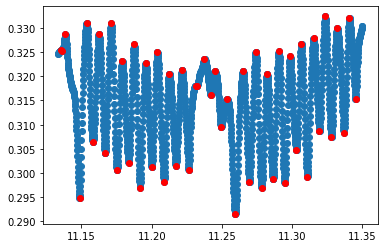

In [39]:
from scipy.signal import argrelextrema

timeseries_df = cam1_df.copy()
x = timeseries_df['Vertical'].to_numpy()

# for local maxima
maxima = argrelextrema(x, np.greater)

# for local minima
minima = argrelextrema(x, np.less)

plt.scatter(timeseries_df['time'], timeseries_df['Vertical'])

for m in maxima:
    plt.scatter(timeseries_df['time'][m], timeseries_df['Vertical'][m], color='red')
    
for m in minima:
    plt.scatter(timeseries_df['time'][m], timeseries_df['Vertical'][m], color='red')
    
    
maxima_times = timeseries_df.iloc[maxima]['time'].to_numpy()
minima_times = timeseries_df.iloc[minima]['time'].to_numpy()

maxima_diffs = np.diff(maxima_times)
minima_diffs = np.diff(minima_times)

print(maxima_diffs.mean()*60, ' seconds')
print(minima_diffs.mean()*60, ' seconds')

In [ ]:
yd_df['COM_X']

plt.scatter(df1_fwd['time_int'], df1_fwd['COM_X'])

In [ ]:
var = 'COM_Y'
timeseries_df = df1_bwd.copy()

x = timeseries_df[var].to_numpy()

# for local maxima
maxima = argrelextrema(x, np.greater)

# for local minima
minima = argrelextrema(x, np.less)

print("maxima: ", maxima)
print("minima: ", minima)

plt.scatter(timeseries_df['time_int'], timeseries_df[var])

for m in maxima:
    print(m)
    print(timeseries_df['time_int'][m])
    plt.scatter(timeseries_df['time_int'][m], timeseries_df[var][m], color='red')
    
for m in minima:
    print(m)
    plt.scatter(timeseries_df['time_int'][m], timeseries_df[var][m], color='red')
    
    
maxima_times = timeseries_df.iloc[maxima]['time_int'].to_numpy()
minima_times = timeseries_df.iloc[minima]['time_int'].to_numpy()

print(maxima_times)
print(minima_times)

maxima_diffs = np.diff(maxima_times)
minima_diffs = np.diff(minima_times)

print(maxima_diffs.mean()*60, ' seconds')
print(minima_diffs.mean()*60, ' seconds')

##### Plotting MCL center of mass

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
os.listdir("../mcl experiments/mcl data/mcl_3_17")

In [ ]:
# yd_df_com.plot(x='time_int', y='COM_Y', title='YD COM Y')
# cam1_df.plot(x='time', y='Vertical', title='YD COM X')

type(list(cam1_df['time'])[0])

In [ ]:
# plt.scatter(cam1_df['time'], cam1_df['Horizontal'])
plt.scatter(gk_df_com_clean['time_int'], gk_df_com_clean['COM_Y'], color='green')
# plt.scatter()
plt.show()

plt.scatter(x=cam1_df['time'], y=cam1_df['Horizontal'])
# plt.scatter(gk_df_com_clean['time_int'], gk_df_com_clean['COM_Y'], color='green')
# plt.scatter()
plt.show()

In [ ]:
cam1_df

In [ ]:
%matplotlib auto

In [ ]:
list(gk_df_com_clean['time_int'])[:600]

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

from functools import partial

In [ ]:
# GENERATE ANIMATIONS 

fig, ax = plt.subplots()
width, height = 640, 480

def init():
    ax.set_xlim([0, width])
    ax.set_ylim([height, 0])
    ax.set_title(f"{month}/{day}/{year}")
    return ax

def animate3(frame, coral_df, fig, ax, detection_threshold=0.0):
    
    # animates a single frame
    timestamp = times[frame]
    
    poses = coral_df.loc[coral_df['time_int']==timestamp]
    
    ax.clear()
    ax.set_title(f"{month}/{day}/{year}")
    for pos in range(len(poses)):
        pose = poses.iloc[pos].to_dict()
    
        width, height = 640, 480
        all_x_coords, all_y_coords, probs = [], [], []
        x_coords, y_coords = [], []

        for kp in keypoints:
            all_x_coords.append(pose[kp][0])
            all_y_coords.append(pose[kp][1])
            probs.append(pose[kp][2])

            if pose[kp][2] > detection_threshold:
                x_coords.append(pose[kp][0])
                y_coords.append(pose[kp][1])
        ax.scatter(x=x_coords, y=y_coords)
#         ax.scatter(x=x_coords, y=y_coords, color='blue')
        ax.text(430.0, 20.0, f"time: {np.round(timestamp,4)}")
        ax.text(430.0, 60.0, f"frame: {frame}")
        for i,j in num_edges:
            if probs[i] > detection_threshold and probs[j] > detection_threshold:
                xs, ys = [all_x_coords[i], all_x_coords[j]], [all_y_coords[i], all_y_coords[j]]
                plt.plot(xs, ys, color='black')
        ax.set_xlim([0, width])
    ax.set_ylim([height, 0])
    
    return ax

coral_dataframes = [c1_df.copy(), c2_df.copy(), c3_df.copy(), c4_df.copy()]
file_titles = ['c1_df', 'c2_df', 'c3_df', 'c4_df']

for i in range(len(coral_dataframes)):
    coral_df = coral_dataframes[i]
    vid_title = file_titles[i] + '.mp4'
# coral_df = c1_df.copy()
    times = coral_df['time_int'].unique()
    # ani = FuncAnimation(fig, animate, interval=10)
    ani = FuncAnimation(fig, partial(animate3, coral_df=coral_df, fig=fig, ax=ax), frames=len(times)-1, init_func=init)
    # ani = FuncAnimation(fig, partial(animate2, coral_df=coral_df, fig=fig, ax=ax), interval=len(coral_df)-3, save_count=len(coral_df)-3, repeat=False)
    plt.show()
    
    # save animation:
    writervideo = FFMpegWriter(fps=20)
    ani.save(vid_title, writer=writervideo)

In [ ]:
# save animation
f = "tuned_goose_long.mp4"
writervideo = FFMpegWriter(fps=20)
ani.save(f, writer=writervideo)

In [ ]:
fig, ax = plt.subplots()
width, height = 640, 480

# GENERATE ANIMATIONS 

df_plot = gk_df_crop.copy()
times = df_plot['time'].unique()
ani = FuncAnimation(fig, partial(animate3, coral_df=df_plot, fig=fig, ax=ax), frames=40, init_func=init)
plt.show()

In [ ]:
# save animation
f = "green_kid.mp4"
writervideo = FFMpegWriter(fps=30)
ani.save(f, writer=writervideo)

In [ ]:
fig, ax = plt.subplots()
width, height = 640, 480

# GENERATE ANIMATIONS 

df_plot = yd_df_crop.copy()
times = df_plot['time'].unique()
ani = FuncAnimation(fig, partial(animate3, coral_df=df_plot, fig=fig, ax=ax), frames=67, init_func=init)
plt.show()

In [ ]:
# save animation
f = "CAM2.mp4"
writervideo = FFMpegWriter(fps=20)
ani.save(f, writer=writervideo)

## com plots

In [ ]:
def animate4(frame, coral_df, fig, ax, detection_threshold=0.0):
    
    # animates a single frame
    timestamp = times[frame]
    
    poses = coral_df.loc[coral_df['time']==timestamp]
    
    ax.clear()
    ax.set_title(f"{month}/{day}/{year}")
    for pos in range(len(poses)):
        pose = poses.iloc[pos].to_dict()
        if (pose['COM_X'] > 200) and (pose['COM_X'] < 500):
    
            width, height = 640, 480
            all_x_coords, all_y_coords, probs = [], [], []
            x_coords, y_coords = [], []

            for kp in keypoints:
                all_x_coords.append(pose[kp][0])
                all_y_coords.append(pose[kp][1])
                probs.append(pose[kp][2])

                if pose[kp][2] > detection_threshold:
                    x_coords.append(pose[kp][0])
                    y_coords.append(pose[kp][1])
            ax.scatter(x=x_coords, y=y_coords)
            ax.scatter(x=pose['COM_X'], y=pose['COM_Y'], color='red')

            ax.text(430.0, 20.0, f"time: {timestamp}")
            ax.text(430.0, 40.0, f"frame: {frame}")
            for i,j in num_edges:
                if probs[i] > detection_threshold and probs[j] > detection_threshold:
                    xs, ys = [all_x_coords[i], all_x_coords[j]], [all_y_coords[i], all_y_coords[j]]
                    plt.plot(xs, ys, color='black')
            ax.set_xlim([0, width])
            ax.set_ylim([height, 0])
    
    return ax

In [ ]:
fig, ax = plt.subplots()
width, height = 640, 480

# GENERATE ANIMATIONS 

df_plot = yd_df_com
times = df_plot['time'].unique()
ani = FuncAnimation(fig, partial(animate4, coral_df=df_plot, fig=fig, ax=ax), init_func=init)
plt.show()

In [ ]:
fig, ax = plt.subplots()
width, height = 640, 480

# GENERATE ANIMATIONS 

df_plot = gk_df_com
times = df_plot['time'].unique()
ani = FuncAnimation(fig, partial(animate4, coral_df=df_plot, fig=fig, ax=ax), frames=142, init_func=init)
plt.show()


In [ ]:
# save animation
f = "CAM1.mp4"
writervideo = FFMpegWriter(fps=20)
ani.save(f, writer=writervideo)

In [ ]:
fig, ax = plt.subplots()
width, height = 640, 480

# GENERATE ANIMATIONS 

df_plot = tg_df_com
times = df_plot['time'].unique()
ani = FuncAnimation(fig, partial(animate4, coral_df=df_plot, fig=fig, ax=ax), init_func=init)
plt.show()